In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import MDAnalysis as mda

h5_filename = r"output_rrcs_A_vs_B\rrcs_results_rrcs.h5"  
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"

with h5py.File(h5_filename, 'r') as hf:
    residue_pairs_A = hf['residue_pairs_A'][:]  
    residue_pairs_B = hf['residue_pairs_B'][:]  
    times = hf['times'][:]                    
    rrcs = hf['rrcs'][:]   

u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1 or resname AIB or resname ALY) and chainid A")
proteinB_pdb = u_pdb.select_atoms("protein and chainid B")

resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
resid_to_resname_B = {res.resid: res.resname for res in proteinB_pdb.residues}

C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
amino_acid_properties = {
'ALA': 'Hydrophobic', 'VAL': 'Hydrophobic', 'LEU': 'Hydrophobic', 'ILE': 'Hydrophobic',
    'PRO': 'Special', 'MET': 'Hydrophobic',
    'PHE': 'Aromatic', 'TYR': 'Aromatic', 'TRP': 'Aromatic',
    'HIS': 'Charged', 'LYS': 'Charged', 'ARG': 'Charged',
    'ASP': 'Charged', 'GLU': 'Charged',
    'ASN': 'Polar uncharged', 'GLN': 'Polar uncharged', 'SER': 'Polar uncharged', 'THR': 'Polar uncharged',
    'CYS': 'Special', 'GLY': 'Special', 'SEC': 'Special', 'UNK': 'Special',
    'PL1': 'Hydrophobic', 'AIB': 'Hydrophobic', 'ALY':'Special'
}

property_colors = {
    'Hydrophobic': '#7A7A7A',               # Royal Blue
    'Aromatic': '#800080',     # Purple
    'Charged': '#FF0000',      # Red
    'Polar uncharged': '#008000',           # Green
    'Special': '#FFA500'                     # Orange
}

In [3]:
def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Special')

resid_to_property_A = {}
for resid, resname in resid_to_resname_A.items():
    prop = get_amino_acid_property(resname)
    resid_to_property_A[resid] = prop

resid_to_property_A

{1: 'Special',
 2: 'Hydrophobic',
 3: 'Polar uncharged',
 4: 'Special',
 5: 'Polar uncharged',
 6: 'Aromatic',
 7: 'Polar uncharged',
 8: 'Polar uncharged',
 9: 'Charged',
 10: 'Special',
 11: 'Polar uncharged',
 12: 'Charged',
 13: 'Aromatic',
 14: 'Hydrophobic',
 15: 'Charged',
 16: 'Charged',
 17: 'Charged',
 18: 'Hydrophobic',
 19: 'Hydrophobic',
 20: 'Polar uncharged',
 21: 'Charged',
 22: 'Aromatic',
 23: 'Hydrophobic',
 24: 'Polar uncharged',
 25: 'Aromatic',
 26: 'Hydrophobic',
 27: 'Hydrophobic',
 28: 'Charged',
 29: 'Special',
 30: 'Special',
 31: 'Special',
 32: 'Polar uncharged',
 33: 'Polar uncharged',
 34: 'Special',
 35: 'Hydrophobic',
 36: 'Special',
 37: 'Special',
 38: 'Special',
 39: 'Polar uncharged',
 40: 'Hydrophobic'}

In [4]:
resid_to_property_B = {}
for resid, resname in resid_to_resname_B.items():
    prop = get_amino_acid_property(resname)
    resid_to_property_B[resid] = prop

In [5]:
bt = 500000.0   # 500 ns in ps
et = 1000000.0  # 1000 ns in ps
time_indices = np.where((times >= bt) & (times <= et))[0]
filtered_times = times[time_indices]
filtered_rrcs = rrcs[:, time_indices]

In [6]:
unique_resid_B = np.unique(residue_pairs_B)
rrcs_sum_B_filtered = {resid: np.zeros(len(filtered_times), dtype=np.float32) for resid in unique_resid_B}

In [7]:
for i in tqdm(range(len(residue_pairs_B)), desc="Accumulating RRCS sums"):
    b_resid = residue_pairs_B[i]
    rrcs_sum_B_filtered[b_resid] += filtered_rrcs[i]

Accumulating RRCS sums: 100%|██████████| 15840/15840 [00:00<00:00, 22174.98it/s]


In [8]:
averaged_rrcs_sum_B = {}
averaged_rrcs_values_B = {}
frames_per_average = 100


for resid in unique_resid_B:
    rrcs_sum = rrcs_sum_B_filtered[resid]
    num_complete_averages = len(rrcs_sum) // frames_per_average
    if num_complete_averages == 0:
        print(f"Residue {resid} has less than {frames_per_average} frames.")
        continue
    rrcs_sum_trimmed = rrcs_sum[:num_complete_averages * frames_per_average]
    # Reshape and compute mean
    averaged_rrcs = rrcs_sum_trimmed.reshape(-1, frames_per_average).mean(axis=1)
    averaged_rrcs_sum_B[resid] = averaged_rrcs.mean()
    averaged_rrcs_values_B[resid] = averaged_rrcs

In [83]:
# averaged_rrcs_sum_B
# averaged_rrcs_values_B

In [9]:
data_for_plot_B = []
for resid in unique_resid_B:

    mean = averaged_rrcs_sum_B[resid]
    se = np.std(averaged_rrcs_values_B[resid], ddof=1) / np.sqrt(len(averaged_rrcs_values_B[resid]))
    resname = resid_to_resname_B.get(resid, f"Res{resid}")
    property_B = get_amino_acid_property(resname)
    label = f"{resid}_{resname}"
    data_for_plot_B.append({'Resid':resid ,'Residue': label, 'Mean': mean, 'SE': se, 'Property': property_B, 'Values': averaged_rrcs_values_B[resid]})
    


In [10]:
import pandas as pd
df1_B = pd.DataFrame({
    'Residue': [item['Residue'] for item in data_for_plot_B],
    'Mean': [item['Mean'] for item in data_for_plot_B],
    'SE': [item['SE'] for item in data_for_plot_B],
    'Property': [item['Property'] for item in data_for_plot_B],
    'Resid': [item['Resid'] for item in data_for_plot_B]
})

df2_B = pd.DataFrame({
    'Residue': np.repeat([item['Residue'] for item in data_for_plot_B], len(data_for_plot_B[0]['Values'])),
    'Value': np.concatenate([item['Values'] for item in data_for_plot_B]),
    'Property': np.repeat([item['Property'] for item in data_for_plot_B], len(data_for_plot_B[0]['Values']))
})

In [86]:
df1_B

,Residue,Mean,SE,Property,Resid
0,28_ALA,0.028802,0.010995,Hydrophobic,28
1,29_THR,1.224642,0.173070,Polar uncharged,29
2,30_VAL,6.766381,0.188635,Hydrophobic,30
3,31_SER,10.094324,0.097466,Polar uncharged,31
4,32_LEU,11.361100,0.051251,Hydrophobic,32
...,...,...,...,...,...
391,419_ARG,0.000000,0.000000,Charged,419
392,420_TRP,0.000000,0.000000,Aromatic,420
393,421_ARG,0.000000,0.000000,Charged,421
394,422_LEU,0.000000,0.000000,Hydrophobic,422


In [87]:
df2_B

,Residue,Value,Property
0,28_ALA,0.000000,Hydrophobic
1,28_ALA,0.003636,Hydrophobic
2,28_ALA,0.000000,Hydrophobic
3,28_ALA,0.000000,Hydrophobic
4,28_ALA,0.000000,Hydrophobic
...,...,...,...
19795,423_GLU,0.000000,Charged
19796,423_GLU,0.000000,Charged
19797,423_GLU,0.000000,Charged
19798,423_GLU,0.000000,Charged


In [11]:

df1_B['Color'] = df1_B['Property'].map(property_colors)
df1_B['Color'] = df1_B['Color'].fillna('#000000')
df2_B['Color'] = df2_B['Property'].map(property_colors)
df2_B['Color'] = df2_B['Color'].fillna('#000000')

#### Filter df1_B for Mean > 1

In [12]:
df1_filtered_B_temp = df1_B[df1_B['Mean'] > 0.8].reset_index(drop=True)
df1_filtered_B = df1_filtered_B_temp[df1_filtered_B_temp['Resid'] > 137].reset_index(drop=True)
filtered_residues_B = df1_filtered_B['Residue'].tolist()
filtered_residues_B

['138_GLU',
 '141_LEU',
 '142_LEU',
 '145_TYR',
 '146_ILE',
 '148_TYR',
 '149_THR',
 '150_VAL',
 '153_ALA',
 '154_LEU',
 '190_ARG',
 '197_LYS',
 '201_LEU',
 '202_LYS',
 '205_TYR',
 '207_THR',
 '211_GLN',
 '237_VAL',
 '298_THR',
 '299_ARG',
 '300_ASN',
 '306_TRP',
 '310_ARG',
 '372_ASP',
 '380_ARG',
 '384_LEU',
 '387_GLU',
 '388_LEU',
 '391_THR']

In [13]:
df2_filtered_B = df2_B[df2_B['Residue'].isin(filtered_residues_B)].copy()
df2_filtered_B

,Residue,Value,Property,Color
5500,138_GLU,3.991733,Charged,#FF0000
5501,138_GLU,3.574001,Charged,#FF0000
5502,138_GLU,4.740375,Charged,#FF0000
5503,138_GLU,2.099444,Charged,#FF0000
5504,138_GLU,2.144995,Charged,#FF0000
...,...,...,...,...
18195,391_THR,0.001419,Polar uncharged,#008000
18196,391_THR,0.003806,Polar uncharged,#008000
18197,391_THR,0.000000,Polar uncharged,#008000
18198,391_THR,0.000000,Polar uncharged,#008000


In [ ]:
aa_dict = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y',
    'AIB': 'Aib'  
}

def modify_label(label):
    parts = label.split('_')
    if len(parts) == 2:
        resid, resname = parts
        if resname in aa_dict:

            return f"{aa_dict[resname]}{resid}"
        else:
            return f"{resname}"
    return label


df1_filtered_B['Modified_Residue'] = df1_filtered_B['Residue'].apply(modify_label)
df2_filtered_B['Modified_Residue'] = df2_filtered_B['Residue'].apply(modify_label)

In [92]:
df1_filtered_B

,Residue,Mean,SE,Property,Resid,Color,Modified_Residue
0,138_GLU,3.158822,0.139955,Charged,138,#FF0000,E138
1,141_LEU,3.530374,0.101849,Hydrophobic,141,#7A7A7A,L141
2,142_LEU,2.002509,0.061060,Hydrophobic,142,#7A7A7A,L142
3,145_TYR,2.654033,0.086834,Aromatic,145,#800080,Y145
4,146_ILE,1.285357,0.065641,Hydrophobic,146,#7A7A7A,I146
5,148_TYR,3.856547,0.277270,Aromatic,148,#800080,Y148
6,149_THR,1.300204,0.050703,Polar uncharged,149,#008000,T149
7,150_VAL,1.198300,0.053861,Hydrophobic,150,#7A7A7A,V150
8,153_ALA,1.287004,0.061908,Hydrophobic,153,#7A7A7A,A153
9,154_LEU,0.984614,0.051553,Hydrophobic,154,#7A7A7A,L154


In [93]:
df2_filtered_B

,Residue,Value,Property,Color,Modified_Residue
5500,138_GLU,3.991733,Charged,#FF0000,E138
5501,138_GLU,3.574001,Charged,#FF0000,E138
5502,138_GLU,4.740375,Charged,#FF0000,E138
5503,138_GLU,2.099444,Charged,#FF0000,E138
5504,138_GLU,2.144995,Charged,#FF0000,E138
...,...,...,...,...,...
18195,391_THR,0.001419,Polar uncharged,#008000,T391
18196,391_THR,0.003806,Polar uncharged,#008000,T391
18197,391_THR,0.000000,Polar uncharged,#008000,T391
18198,391_THR,0.000000,Polar uncharged,#008000,T391


In [15]:
df1_plot_B = df1_filtered_B.copy()
df2_plot_B = df2_filtered_B.copy()

In [16]:
residues_sorted_B = df1_plot_B['Modified_Residue'].tolist()
x_positions_B = np.arange(len(residues_sorted_B))
x_positions_B

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [17]:
residue_to_x_B = {residue: x for x, residue in zip(x_positions_B, residues_sorted_B)}
residue_to_x_B

{'E138': 0,
 'L141': 1,
 'L142': 2,
 'Y145': 3,
 'I146': 4,
 'Y148': 5,
 'T149': 6,
 'V150': 7,
 'A153': 8,
 'L154': 9,
 'R190': 10,
 'K197': 11,
 'L201': 12,
 'K202': 13,
 'Y205': 14,
 'T207': 15,
 'Q211': 16,
 'V237': 17,
 'T298': 18,
 'R299': 19,
 'N300': 20,
 'W306': 21,
 'R310': 22,
 'D372': 23,
 'R380': 24,
 'L384': 25,
 'E387': 26,
 'L388': 27,
 'T391': 28}

In [18]:
df2_plot_B['X_num'] = df2_plot_B['Modified_Residue'].map(residue_to_x_B)
df2_clean_B = df2_plot_B.dropna(subset=['X_num'])
df2_clean_B

,Residue,Value,Property,Color,Modified_Residue,X_num
5500,138_GLU,3.991733,Charged,#FF0000,E138,0
5501,138_GLU,3.574001,Charged,#FF0000,E138,0
5502,138_GLU,4.740375,Charged,#FF0000,E138,0
5503,138_GLU,2.099444,Charged,#FF0000,E138,0
5504,138_GLU,2.144995,Charged,#FF0000,E138,0
...,...,...,...,...,...,...
18195,391_THR,0.001419,Polar uncharged,#008000,T391,28
18196,391_THR,0.003806,Polar uncharged,#008000,T391,28
18197,391_THR,0.000000,Polar uncharged,#008000,T391,28
18198,391_THR,0.000000,Polar uncharged,#008000,T391,28


In [19]:
# Create jittered x positions
jitter_strength = 0.25  # Adjust for more or less jitter
np.random.seed(114514)  # For reproducibility
jitter_B = np.random.uniform(-jitter_strength, jitter_strength, size=df2_clean_B.shape[0])
jitter_B

array([ 0.09387794,  0.08808647, -0.03669428, ...,  0.18187406,
       -0.14061642,  0.03170879])

In [20]:
scatter_colors_B = df2_clean_B['Color'].values
scatter_colors_B

array(['#FF0000', '#FF0000', '#FF0000', ..., '#008000', '#008000',
       '#008000'], dtype=object)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


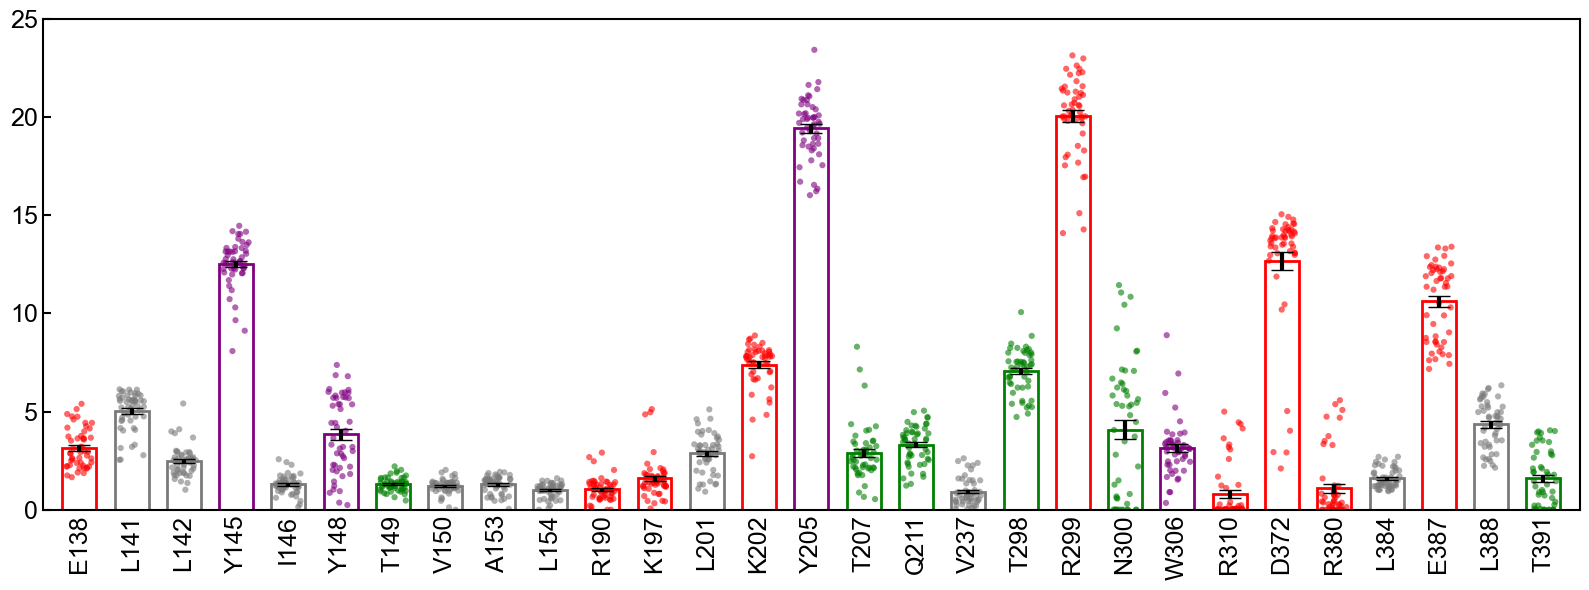

In [ ]:
plt.figure(figsize=(16, 6), facecolor='white')
bars_B = plt.bar(x_positions_B, df1_plot_B['Mean'], yerr=df1_plot_B['SE'], 
                 color='white', edgecolor=df1_plot_B['Color'], linewidth=2, 
                 width=0.65, label='Mean RRCS', capsize=5, error_kw=dict(lw=3, capsize=8))


plt.scatter(df2_clean_B['X_num'] + jitter_B, df2_clean_B['Value'], 
            color=scatter_colors_B, alpha=0.6, 
            edgecolor='none', s=20, label='Individual RRCS',marker = 'o')


plt.ylim(0, 25)
plt.xticks(x_positions_B, df1_plot_B['Modified_Residue'], rotation=90, fontsize=18)
plt.yticks(fontsize=18)


ax = plt.gca()


ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)


for spine in ['bottom', 'left', 'top', 'right']:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1.5)


ax.tick_params(axis='both', which='major', direction='in', length=6, width=1.5, colors='black',left=True)


# ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', length=6, width=1.5, colors='black')
# ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', length=6, width=1.5, colors='black')


padding = 0.7  
ax.set_xlim(min(x_positions_B) - padding, max(x_positions_B) + padding)


ax.set_facecolor('white')


plt.grid(False)
plt.tight_layout()


out_filename_B = "final_figure2/Recptor_500ns_1000ns_Filtered_bar.eps"
plt.savefig(out_filename_B, format='eps', transparent=False)
plt.show()


## Then start running the density time chart

In [28]:
properties = list(property_colors.keys())
properties

['Hydrophobic', 'Aromatic', 'Charged', 'Polar uncharged', 'Special']

In [29]:

rrcs_sum_B_properties = {resid: {prop: np.zeros(len(filtered_times), dtype=np.float32) for prop in properties} for resid in df1_filtered_B["Resid"]}
rrcs_sum_B_properties

{138: {'Hydrophobic': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'Aromatic': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'Charged': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'Polar uncharged': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'Special': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)},
 141: {'Hydrophobic': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'Aromatic': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'Charged': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'Polar uncharged': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'Special': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)},
 142: {'Hydrophobic': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'Aromatic': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'Charged': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'Polar uncharged': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'Special': array([

In [30]:
for i in tqdm(range(len(residue_pairs_B)), desc="Accumulating RRCS sums by property"):
    b_resid = residue_pairs_B[i]
    if b_resid not in list(df1_filtered_B["Resid"]):
        continue
    a_resid = residue_pairs_A[i]
    property_A = resid_to_property_A.get(a_resid, 'Special') 
    rrcs_value = filtered_rrcs[i]  # Shape: (filtered_frames,)
    rrcs_sum_B_properties[b_resid][property_A] += rrcs_value

Accumulating RRCS sums by property: 100%|██████████| 15840/15840 [00:01<00:00, 15070.05it/s]


In [31]:
df1_filtered_B["Resid"]

0     138
1     141
2     142
3     145
4     146
5     148
6     149
7     150
8     153
9     154
10    190
11    197
12    201
13    202
14    205
15    207
16    211
17    237
18    298
19    299
20    300
21    306
22    310
23    372
24    380
25    384
26    387
27    388
28    391
Name: Resid, dtype: int32

In [105]:
rrcs_sum_B_properties

{138: {'Hydrophobic': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'Aromatic': array([0.6119246 , 0.31184658, 0.40539938, ..., 4.0757465 , 1.1228745 ,
         1.4240165 ], dtype=float32),
  'Charged': array([0.3874011 , 1.5549917 , 1.1831045 , ..., 0.3683239 , 0.33820605,
         0.29313844], dtype=float32),
  'Polar uncharged': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'Special': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)},
 141: {'Hydrophobic': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'Aromatic': array([1.6670984 , 4.4878097 , 2.767968  , ..., 0.25160006, 0.05379811,
         1.2197047 ], dtype=float32),
  'Charged': array([1.2232875 , 0.09757596, 0.        , ..., 0.5311017 , 1.0176462 ,
         0.1896953 ], dtype=float32),
  'Polar uncharged': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
  'Special': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)},
 142: {'Hydrophobic': array([2.2487152 , 0.84464186, 2.4143078 , ..., 0.43

In [32]:
num_residues = len(df1_filtered_B["Resid"])
simulation_duration = (et - bt)/1000.0
time_per_residue = simulation_duration
residue_duration = simulation_duration
concatenated_rrcs = {prop: [] for prop in properties}
concatenated_labels = []
current_time = 0.0

gap_fraction = 0.5
gap_duration = gap_fraction * residue_duration
time_per_residue_with_gap = residue_duration + gap_duration

total_time_with_gaps = num_residues * time_per_residue_with_gap

In [48]:
sorted_resid_B = sorted(rrcs_sum_B_properties.keys())
sorted_resid_B

[138,
 141,
 142,
 145,
 146,
 148,
 149,
 150,
 153,
 154,
 190,
 197,
 201,
 202,
 205,
 207,
 211,
 237,
 298,
 299,
 300,
 306,
 310,
 372,
 380,
 384,
 387,
 388,
 391]

# filter

In [49]:
smoothed_density_data_per_property = {prop: [] for prop in properties}

In [50]:
x_list = []
concatenated_labels = []
density_data_per_property = {prop: [] for prop in properties}
window_size = 1000

In [ ]:
for residue_index, resid in enumerate(sorted_resid_B):
    resname = resid_to_resname_B.get(resid, f"Res{resid}")
    label = f"{resid}_{resname}"
    label = modify_label(label)
    concatenated_labels.append(label)
    
    start_time = residue_index * time_per_residue_with_gap
    end_time = start_time + residue_duration
    x_residue = np.linspace(start_time, end_time, len(filtered_times))
    x_list.extend(x_residue)
    for prop in properties:
        density_residue = rrcs_sum_B_properties[resid][prop]

        density_residue_series = pd.Series(density_residue)
        smoothed_density_residue = density_residue_series.rolling(window=window_size, min_periods=1, center=True).mean().values
        smoothed_density_data_per_property[prop].extend(smoothed_density_residue)
    

    gap_start = end_time
    gap_end = gap_start + gap_duration

    len_filtered_times_gap = max(1, int(len(filtered_times) * gap_fraction))
    x_gap = np.linspace(gap_start, gap_end, len_filtered_times_gap)
    x_list.extend(x_gap)
    
    for prop in properties:
        density_gap = [0] * len_filtered_times_gap 
        smoothed_density_data_per_property[prop].extend(density_gap)

In [52]:
x = np.array(x_list)

In [ ]:

smoothed_density_data = np.array([smoothed_density_data_per_property[prop] for prop in properties])

boundary_times = [residue_index * time_per_residue_with_gap for residue_index in range(num_residues + 1)]
midpoints = [start_time + (residue_duration / 2) for start_time in boundary_times[:-1]]

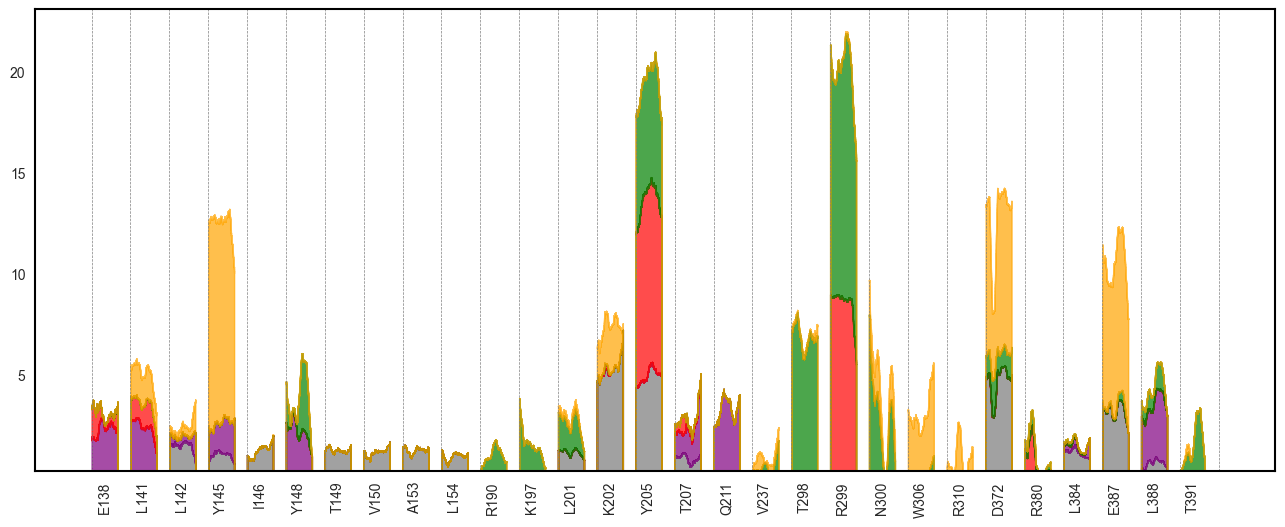

In [ ]:
plt.figure(figsize=(16, 6))
bottom_smoothed = np.zeros_like(x)
for idx, prop in enumerate(properties):
    plt.fill_between(x, bottom_smoothed, bottom_smoothed + smoothed_density_data[idx], 
                     color=property_colors[prop], label=prop, alpha=0.7, step='post')
    bottom_smoothed += smoothed_density_data[idx]

for boundary in boundary_times:
    plt.axvline(x=boundary, color='grey', linestyle='--', linewidth=0.5)
  
plt.xticks(midpoints, concatenated_labels, rotation=90)
plt.ylim(0.25)
ax = plt.gca()
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_color('black')
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(1.5)

plt.grid(False)
out_filename_B = "final_figure/Recptor_500ns_1000ns_Filtered_density_toge.png"
plt.savefig(out_filename_B, format='png', transparent=False)
plt.show()

Accumulating RRCS sums by property: 100%|██████████| 15840/15840 [00:00<00:00, 158240.56it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


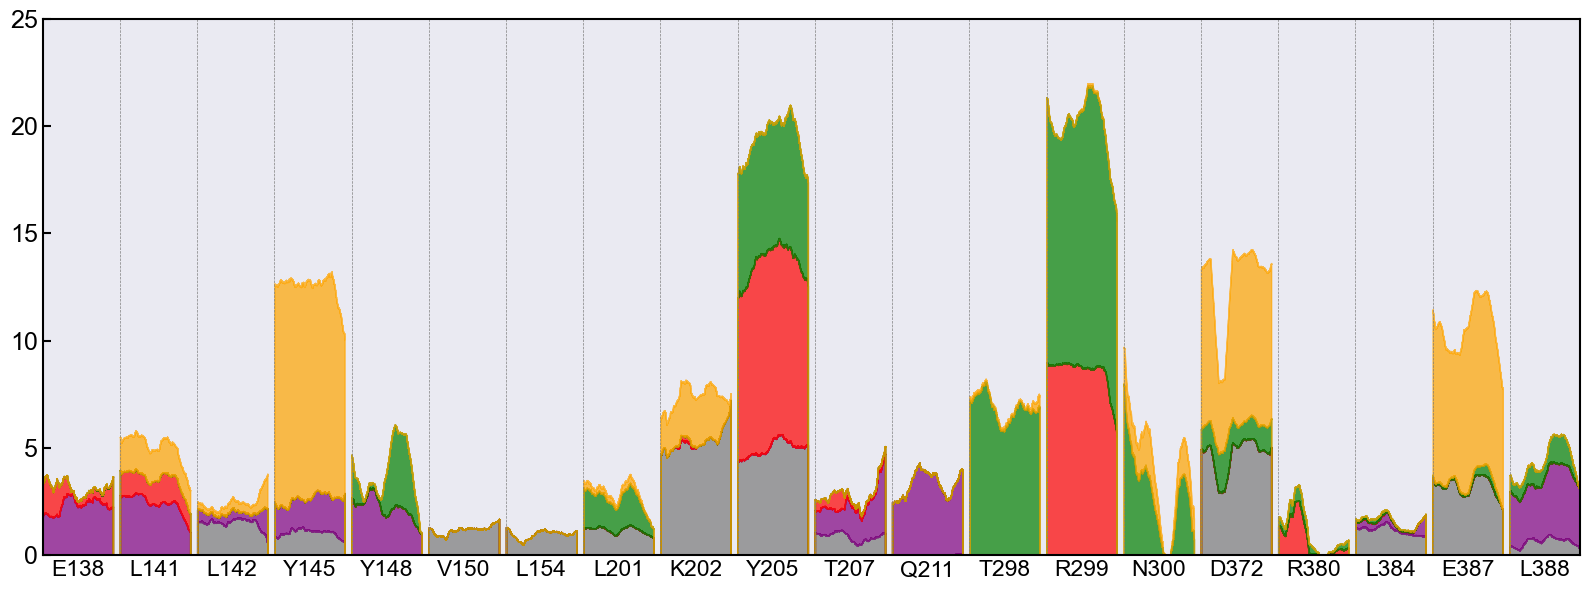

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import MDAnalysis as mda
import pandas as pd

h5_filename = r"output_rrcs_A_vs_B\rrcs_results_rrcs.h5"  
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"

with h5py.File(h5_filename, 'r') as hf:
    residue_pairs_A = hf['residue_pairs_A'][:]  
    residue_pairs_B = hf['residue_pairs_B'][:]  
    times = hf['times'][:]                    
    rrcs = hf['rrcs'][:]   

u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1 or resname AIB or resname ALY) and chainid A")
proteinB_pdb = u_pdb.select_atoms("protein and chainid B")

resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
resid_to_resname_B = {res.resid: res.resname for res in proteinB_pdb.residues}

amino_acid_properties = {
'ALA': 'Hydrophobic', 'VAL': 'Hydrophobic', 'LEU': 'Hydrophobic', 'ILE': 'Hydrophobic',
    'PRO': 'Special', 'MET': 'Hydrophobic',
    'PHE': 'Aromatic', 'TYR': 'Aromatic', 'TRP': 'Aromatic',
    'HIS': 'Charged', 'LYS': 'Charged', 'ARG': 'Charged',
    'ASP': 'Charged', 'GLU': 'Charged',
    'ASN': 'Polar uncharged', 'GLN': 'Polar uncharged', 'SER': 'Polar uncharged', 'THR': 'Polar uncharged',
    'CYS': 'Special', 'GLY': 'Special', 'SEC': 'Special', 'UNK': 'Special',
    'PL1': 'Hydrophobic', 'AIB': 'Hydrophobic', 'ALY':'Special'
}

property_colors = {
    'Hydrophobic': '#7A7A7A',               # Royal Blue
    'Aromatic': '#800080',     # Purple
    'Charged': '#FF0000',      # Red
    'Polar uncharged': '#008000',           # Green
    'Special': '#FFA500'                     # Orange
}
def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Special')

resid_to_property_A = {resid: get_amino_acid_property(resname) for resid, resname in resid_to_resname_A.items()}
resid_to_property_B = {resid: get_amino_acid_property(resname) for resid, resname in resid_to_resname_B.items()}

bt = 500000.0   # 500 ns in ps
et = 1000000.0  # 1000 ns in ps
time_indices = np.where((times >= bt) & (times <= et))[0]
filtered_times = times[time_indices]
filtered_rrcs = rrcs[:, time_indices]


selected_residues_B = [138, 141, 142, 145, 148, 150, 154, 201, 202, 205, 207, 211, 298, 299, 300, 372, 380, 384, 387, 388]
properties = list(property_colors.keys())

rrcs_sum_B_properties = {resid: {prop: np.zeros(len(filtered_times), dtype=np.float32) for prop in properties} for resid in selected_residues_B}


for i in tqdm(range(len(residue_pairs_B)), desc="Accumulating RRCS sums by property"):
    b_resid = residue_pairs_B[i]
    if b_resid not in selected_residues_B:
        continue
    a_resid = residue_pairs_A[i]
    property_A = resid_to_property_A.get(a_resid, 'Special') 
    rrcs_value = filtered_rrcs[i]  # Shape: (filtered_frames,)
    rrcs_sum_B_properties[b_resid][property_A] += rrcs_value


num_residues = len(selected_residues_B)
simulation_duration = (et - bt)/1000.0
residue_duration = simulation_duration
gap_fraction = 0.1
gap_duration = gap_fraction * residue_duration
time_per_residue_with_gap = residue_duration + gap_duration
total_time_with_gaps = num_residues * time_per_residue_with_gap


sorted_resid_B = selected_residues_B


smoothed_density_data_per_property = {prop: [] for prop in properties}
x_list = []
concatenated_labels = []
window_size = 1000  

aa_dict = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y',
    'AIB': 'AIB', 'PL1': 'PL1'
}

def modify_label(label):
    parts = label.split('_')
    if len(parts) == 2:
        resid, resname = parts
        if resname in aa_dict:
            return f"{aa_dict[resname]}{resid}"
        else:
            return f"{resname}{resid}"
    return label

for residue_index, resid in enumerate(sorted_resid_B):
    resname = resid_to_resname_B.get(resid, f"Res{resid}")
    label = f"{resid}_{resname}"
    label = modify_label(label)
    concatenated_labels.append(label)
    
    start_time = residue_index * time_per_residue_with_gap
    end_time = start_time + residue_duration    

    x_residue = np.linspace(start_time, end_time, len(filtered_times))
    x_list.extend(x_residue)
    
    for prop in properties:
        density_residue = rrcs_sum_B_properties[resid][prop]
        density_residue_series = pd.Series(density_residue)
        smoothed_density_residue = density_residue_series.rolling(window=window_size, min_periods=1, center=True).mean().values
        smoothed_density_data_per_property[prop].extend(smoothed_density_residue)
    
    gap_start = end_time
    gap_end = gap_start + gap_duration
    len_filtered_times_gap = max(1, int(len(filtered_times) * gap_fraction))
    x_gap = np.linspace(gap_start, gap_end, len_filtered_times_gap)
    x_list.extend(x_gap)
    for prop in properties:
        density_gap = [0] * len_filtered_times_gap  
        smoothed_density_data_per_property[prop].extend(density_gap)

x = np.array(x_list)
smoothed_density_data = np.array([smoothed_density_data_per_property[prop] for prop in properties])
boundary_times = [residue_index * time_per_residue_with_gap for residue_index in range(num_residues)]
boundary_times.append(boundary_times[-1] + residue_duration)

midpoints = [start_time + (residue_duration / 2) for start_time in boundary_times[:-1]]

plt.figure(figsize=(16, 6))
bottom_smoothed = np.zeros_like(x)
for idx, prop in enumerate(properties):
    plt.fill_between(x, bottom_smoothed, bottom_smoothed + smoothed_density_data[idx], 
                     color=property_colors[prop], label=prop, alpha=0.7, step='post')
    bottom_smoothed += smoothed_density_data[idx]


for boundary in boundary_times[:-1]:  
    plt.axvline(x=boundary, color='grey', linestyle='--', linewidth=0.5)

plt.xticks(midpoints, concatenated_labels, rotation=0, fontsize=16.5)
plt.ylim(0, 25)
plt.yticks(fontsize=18)
plt.xlim(boundary_times[0], boundary_times[-1])

ax = plt.gca()
for spine in ['bottom', 'left', 'right', 'top']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1.5)
ax.tick_params(axis='both', which='major', direction='in', length=6, width=1.5, colors='black',left=True)

# plt.legend(title="Residue A's Properties", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
# plt.legend().set_visible(False)

plt.grid(False)
out_filename_B = "final_figure2/Recptor_500ns_1000ns_Filtered_density.eps"
plt.tight_layout()
plt.savefig(out_filename_B, format='eps', transparent=False)
plt.show()

Accumulating RRCS sums by property: 100%|██████████| 15840/15840 [00:00<00:00, 127694.48it/s]


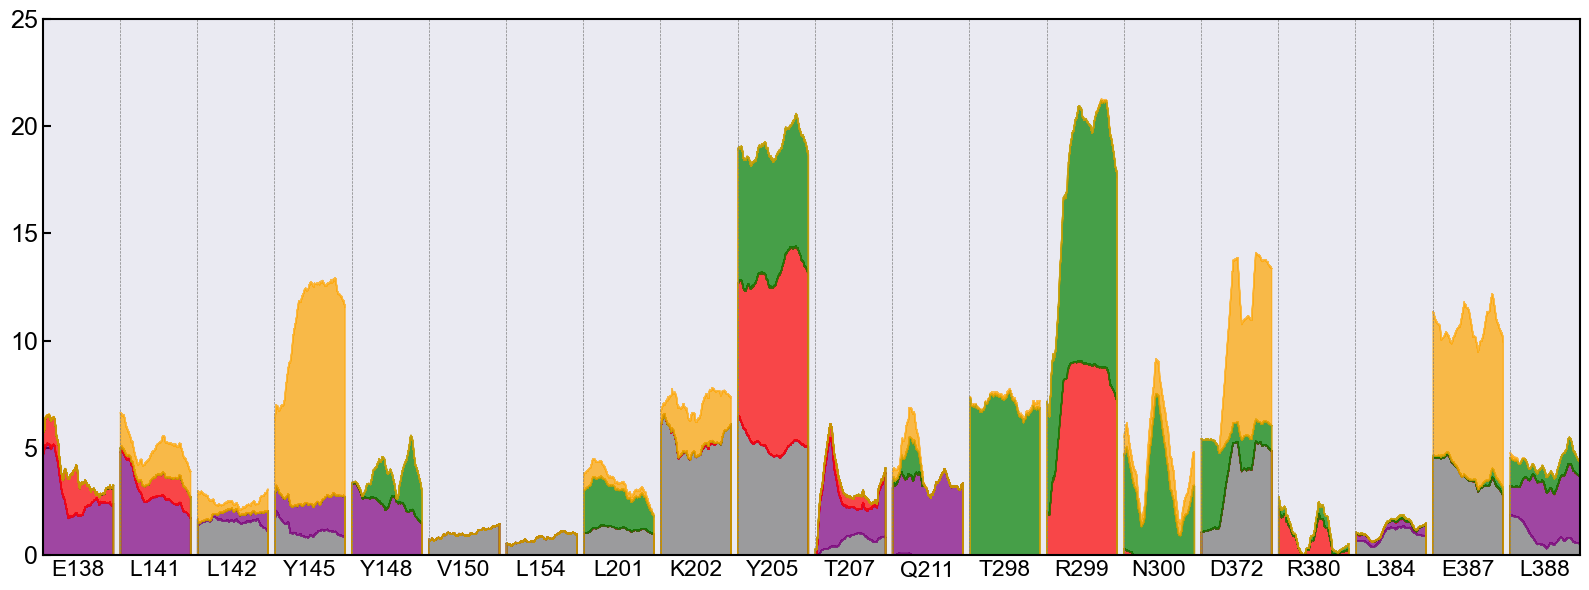

In [ ]:
h5_filename = r"output_rrcs_A_vs_B\rrcs_results_rrcs.h5"  
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"

with h5py.File(h5_filename, 'r') as hf:
    residue_pairs_A = hf['residue_pairs_A'][:]  
    residue_pairs_B = hf['residue_pairs_B'][:]  
    times = hf['times'][:]                    
    rrcs = hf['rrcs'][:]   

u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1 or resname AIB or resname ALY) and chainid A")
proteinB_pdb = u_pdb.select_atoms("protein and chainid B")

resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
resid_to_resname_B = {res.resid: res.resname for res in proteinB_pdb.residues}

amino_acid_properties = {
'ALA': 'Hydrophobic', 'VAL': 'Hydrophobic', 'LEU': 'Hydrophobic', 'ILE': 'Hydrophobic',
    'PRO': 'Special', 'MET': 'Hydrophobic',
    'PHE': 'Aromatic', 'TYR': 'Aromatic', 'TRP': 'Aromatic',
    'HIS': 'Charged', 'LYS': 'Charged', 'ARG': 'Charged',
    'ASP': 'Charged', 'GLU': 'Charged',
    'ASN': 'Polar uncharged', 'GLN': 'Polar uncharged', 'SER': 'Polar uncharged', 'THR': 'Polar uncharged',
    'CYS': 'Special', 'GLY': 'Special', 'SEC': 'Special', 'UNK': 'Special',
    'PL1': 'Hydrophobic', 'AIB': 'Hydrophobic', 'ALY':'Special'
}

property_colors = {
    'Hydrophobic': '#7A7A7A',               # Royal Blue
    'Aromatic': '#800080',     # Purple
    'Charged': '#FF0000',      # Red
    'Polar uncharged': '#008000',           # Green
    'Special': '#FFA500'                     # Orange
}

def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Special')


resid_to_property_A = {resid: get_amino_acid_property(resname) for resid, resname in resid_to_resname_A.items()}
resid_to_property_B = {resid: get_amino_acid_property(resname) for resid, resname in resid_to_resname_B.items()}


bt = 0.0         # 修改起始时间为 0 ns（ps）
et = 1000000.0   # 结束时间保持为 1000 ns（ps）
time_indices = np.where((times >= bt) & (times <= et))[0]
filtered_times = times[time_indices]
filtered_rrcs = rrcs[:, time_indices]


selected_residues_B = [138, 141, 142, 145, 148, 150, 154, 201, 202, 205, 207, 211, 298, 299, 300, 372, 380, 384, 387, 388]

properties = list(property_colors.keys())

rrcs_sum_B_properties = {resid: {prop: np.zeros(len(filtered_times), dtype=np.float32) for prop in properties} for resid in selected_residues_B}

for i in tqdm(range(len(residue_pairs_B)), desc="Accumulating RRCS sums by property"):
    b_resid = residue_pairs_B[i]
    if b_resid not in selected_residues_B:
        continue
    a_resid = residue_pairs_A[i]
    property_A = resid_to_property_A.get(a_resid, 'Special') 
    rrcs_value = filtered_rrcs[i]  # Shape: (filtered_frames,)
    rrcs_sum_B_properties[b_resid][property_A] += rrcs_value
num_residues = len(selected_residues_B)
simulation_duration = (et - bt)/1000.0
residue_duration = simulation_duration
gap_fraction = 0.1
gap_duration = gap_fraction * residue_duration
time_per_residue_with_gap = residue_duration + gap_duration
total_time_with_gaps = num_residues * time_per_residue_with_gap

sorted_resid_B = selected_residues_B
smoothed_density_data_per_property = {prop: [] for prop in properties}
x_list = []
concatenated_labels = []
window_size = 2000  

aa_dict = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y',
    'AIB': 'AIB', 'PL1': 'PL1'
}

def modify_label(label):
    parts = label.split('_')
    if len(parts) == 2:
        resid, resname = parts
        if resname in aa_dict:
            return f"{aa_dict[resname]}{resid}"
        else:
            return f"{resname}{resid}"
    return label

for residue_index, resid in enumerate(sorted_resid_B):
    resname = resid_to_resname_B.get(resid, f"Res{resid}")
    label = f"{resid}_{resname}"
    label = modify_label(label)
    concatenated_labels.append(label)
    
    start_time = residue_index * time_per_residue_with_gap
    end_time = start_time + residue_duration
    
    x_residue = np.linspace(start_time, end_time, len(filtered_times))
    x_list.extend(x_residue)
    
    for prop in properties:
        density_residue = rrcs_sum_B_properties[resid][prop]
        density_residue_series = pd.Series(density_residue)
        smoothed_density_residue = density_residue_series.rolling(window=window_size, min_periods=1, center=True).mean().values
        smoothed_density_data_per_property[prop].extend(smoothed_density_residue)
    
    gap_start = end_time
    gap_end = gap_start + gap_duration
    len_filtered_times_gap = max(1, int(len(filtered_times) * gap_fraction))
    x_gap = np.linspace(gap_start, gap_end, len_filtered_times_gap)
    x_list.extend(x_gap)
    
    for prop in properties:
        density_gap = [0] * len_filtered_times_gap  
        smoothed_density_data_per_property[prop].extend(density_gap)

x = np.array(x_list)

smoothed_density_data = np.array([smoothed_density_data_per_property[prop] for prop in properties])
boundary_times = [residue_index * time_per_residue_with_gap for residue_index in range(num_residues)]
boundary_times.append(boundary_times[-1] + residue_duration)

midpoints = [start_time + (residue_duration / 2) for start_time in boundary_times[:-1]]

plt.figure(figsize=(16, 6))
bottom_smoothed = np.zeros_like(x)
for idx, prop in enumerate(properties):
    plt.fill_between(x, bottom_smoothed, bottom_smoothed + smoothed_density_data[idx], 
                     color=property_colors[prop], label=prop, alpha=0.7, step='post')
    bottom_smoothed += smoothed_density_data[idx]

for boundary in boundary_times[:-1]:  
    plt.axvline(x=boundary, color='grey', linestyle='--', linewidth=0.5)

plt.xticks(midpoints, concatenated_labels, rotation=0, fontsize=16.5)
plt.ylim(0, 25)
plt.yticks(fontsize=18)

plt.xlim(boundary_times[0], boundary_times[-1])

ax = plt.gca()
for spine in ['bottom', 'left', 'right', 'top']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1.5)
ax.tick_params(axis='both', which='major', direction='in', length=6, width=1.5, colors='black', left=True)
# plt.legend(title="Residue A's Properties", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
# plt.legend().set_visible(False)

plt.grid(False)
out_filename_B = "final_figure2/Recptor_0ns_1000ns_Filtered_density.jpg"
plt.tight_layout()
plt.savefig(out_filename_B, format='jpg', transparent=False)
plt.show()


# PL2


PL1 residue IDs in Protein A: [40]


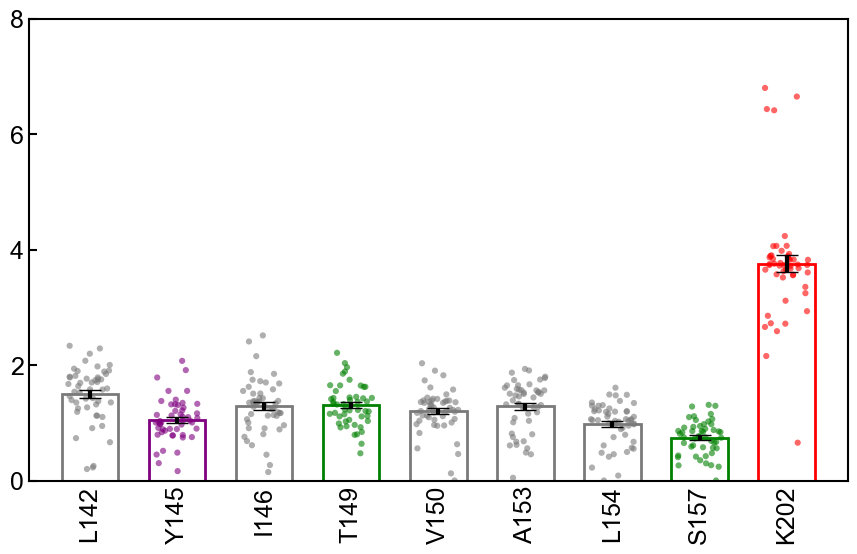

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


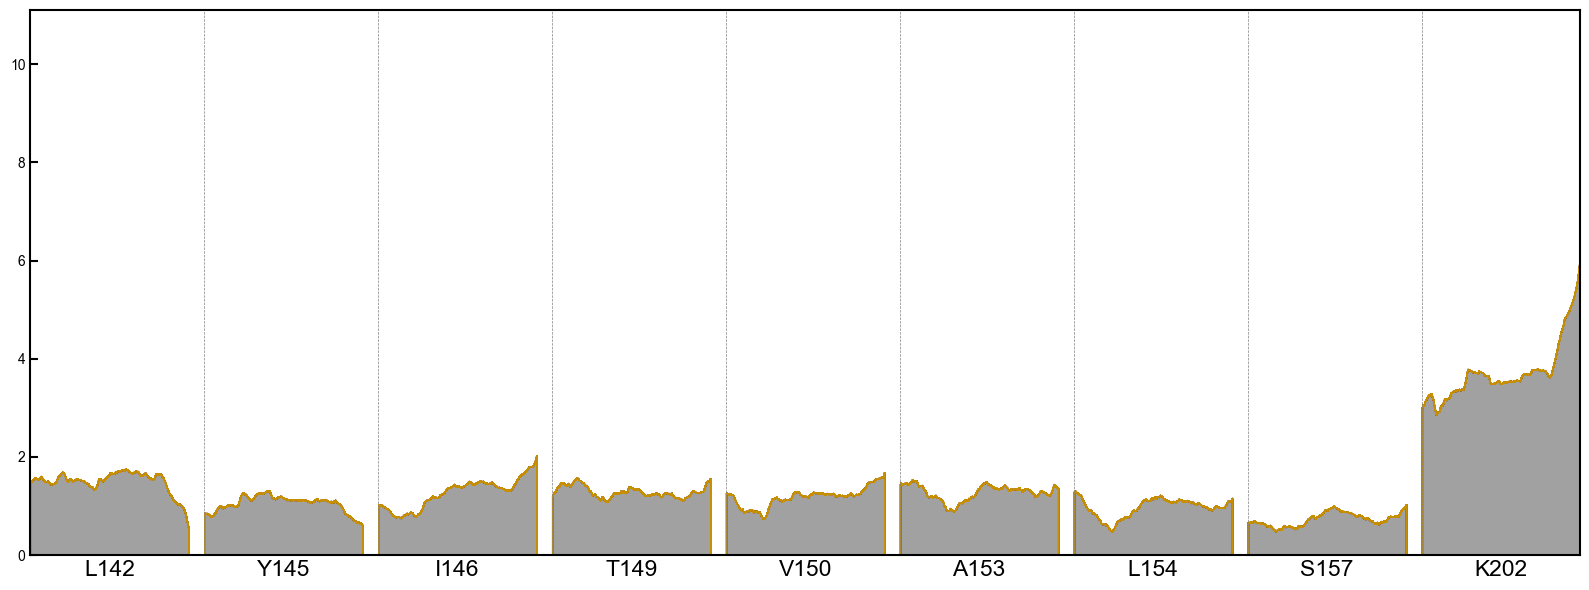

In [ ]:
h5_filename = r"output_rrcs_A_vs_B\rrcs_results_rrcs.h5"  
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"

with h5py.File(h5_filename, 'r') as hf:
    residue_pairs_A = hf['residue_pairs_A'][:]  
    residue_pairs_B = hf['residue_pairs_B'][:]  
    times = hf['times'][:]                    
    rrcs = hf['rrcs'][:]   

u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1 or resname AIB or resname ALY) and chainid A")
proteinB_pdb = u_pdb.select_atoms("protein and chainid B")

resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
resid_to_resname_B = {res.resid: res.resname for res in proteinB_pdb.residues}


amino_acid_properties = {
'ALA': 'Hydrophobic', 'VAL': 'Hydrophobic', 'LEU': 'Hydrophobic', 'ILE': 'Hydrophobic',
    'PRO': 'Special', 'MET': 'Hydrophobic',
    'PHE': 'Aromatic', 'TYR': 'Aromatic', 'TRP': 'Aromatic',
    'HIS': 'Charged', 'LYS': 'Charged', 'ARG': 'Charged',
    'ASP': 'Charged', 'GLU': 'Charged',
    'ASN': 'Polar uncharged', 'GLN': 'Polar uncharged', 'SER': 'Polar uncharged', 'THR': 'Polar uncharged',
    'CYS': 'Special', 'GLY': 'Special', 'SEC': 'Special', 'UNK': 'Special',
    'PL1': 'Hydrophobic', 'AIB': 'Hydrophobic', 'ALY':'Special'
}

property_colors = {
    'Hydrophobic': '#7A7A7A',               # Royal Blue
    'Aromatic': '#800080',     # Purple
    'Charged': '#FF0000',      # Red
    'Polar uncharged': '#008000',           # Green
    'Special': '#FFA500'                     # Orange
}
def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Special')


resid_to_property_A = {resid: get_amino_acid_property(resname) for resid, resname in resid_to_resname_A.items()}
resid_to_property_B = {resid: get_amino_acid_property(resname) for resid, resname in resid_to_resname_B.items()}

bt = 500000.0   # 500 ns in ps
et = 1000000.0  # 1000 ns in ps
time_indices = np.where((times >= bt) & (times <= et))[0]
filtered_times = times[time_indices]


pl1_resids = [resid for resid, resname in resid_to_resname_A.items() if resname == 'PL1']
print("PL1 residue IDs in Protein A:", pl1_resids)

if len(pl1_resids) == 0:
    print("No PL1 residue found in Protein A.")
    pl1_resid = None
else:
    pl1_resid = pl1_resids[0]  

selected_residues_B = [142, 145, 146, 149, 150, 153, 154, 157, 202]


indices = np.where((residue_pairs_A == pl1_resid) & (np.isin(residue_pairs_B, selected_residues_B)))[0]
filtered_residue_pairs_A = residue_pairs_A[indices]
filtered_residue_pairs_B = residue_pairs_B[indices]
filtered_rrcs = rrcs[indices][:, time_indices]


rrcs_sum_B_filtered = {resid: np.zeros(len(filtered_times), dtype=np.float32) for resid in selected_residues_B}

for i in range(len(filtered_residue_pairs_B)):
    b_resid = filtered_residue_pairs_B[i]
    rrcs_sum_B_filtered[b_resid] += filtered_rrcs[i]

averaged_rrcs_sum_B = {}
averaged_rrcs_values_B = {}
frames_per_average = 100 ###

for resid in selected_residues_B:
    rrcs_sum = rrcs_sum_B_filtered[resid]
    num_complete_averages = len(rrcs_sum) // frames_per_average
    if num_complete_averages == 0:
        print(f"Residue {resid} has less than {frames_per_average} frames.")
        continue
    rrcs_sum_trimmed = rrcs_sum[:num_complete_averages * frames_per_average]
    averaged_rrcs = rrcs_sum_trimmed.reshape(-1, frames_per_average).mean(axis=1)
    averaged_rrcs_sum_B[resid] = averaged_rrcs.mean()
    averaged_rrcs_values_B[resid] = averaged_rrcs

data_for_plot_B = []
for resid in selected_residues_B:
    if resid not in averaged_rrcs_sum_B:
        continue
    mean = averaged_rrcs_sum_B[resid]
    se = np.std(averaged_rrcs_values_B[resid], ddof=1) / np.sqrt(len(averaged_rrcs_values_B[resid]))
    resname = resid_to_resname_B.get(resid, f"Res{resid}")
    property_B = get_amino_acid_property(resname)
    label = f"{resid}_{resname}"
    data_for_plot_B.append({'Resid': resid, 'Residue': label, 'Mean': mean, 'SE': se, 'Property': property_B, 'Values': averaged_rrcs_values_B[resid]})

df1_B = pd.DataFrame({
    'Residue': [item['Residue'] for item in data_for_plot_B],
    'Mean': [item['Mean'] for item in data_for_plot_B],
    'SE': [item['SE'] for item in data_for_plot_B],
    'Property': [item['Property'] for item in data_for_plot_B],
    'Resid': [item['Resid'] for item in data_for_plot_B]
})

df2_B = pd.DataFrame({
    'Residue': np.repeat([item['Residue'] for item in data_for_plot_B], len(data_for_plot_B[0]['Values'])),
    'Value': np.concatenate([item['Values'] for item in data_for_plot_B]),
    'Property': np.repeat([item['Property'] for item in data_for_plot_B], len(data_for_plot_B[0]['Values']))
})

aa_dict = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y',
    'AIB': 'AIB', 'PL1': 'PL1'
}

def modify_label(label):
    parts = label.split('_')
    if len(parts) == 2:
        resid, resname = parts
        if resname in aa_dict:
            return f"{aa_dict[resname]}{resid}"
        else:
            return f"{resname}{resid}"
    return label

df1_B['Modified_Residue'] = df1_B['Residue'].apply(modify_label)
df2_B['Modified_Residue'] = df2_B['Residue'].apply(modify_label)

df1_B['Color'] = df1_B['Property'].map(property_colors)
df1_B['Color'] = df1_B['Color'].fillna('#000000')
df2_B['Color'] = df2_B['Property'].map(property_colors)
df2_B['Color'] = df2_B['Color'].fillna('#000000')

df1_plot_B = df1_B.copy()
df2_plot_B = df2_B.copy()

residues_sorted_B = df1_plot_B['Modified_Residue'].tolist()
x_positions_B = np.arange(len(residues_sorted_B))
residue_to_x_B = {residue: x for x, residue in zip(x_positions_B, residues_sorted_B)}

df2_plot_B['X_num'] = df2_plot_B['Modified_Residue'].map(residue_to_x_B)
df2_clean_B = df2_plot_B.dropna(subset=['X_num'])

jitter_strength = 0.25  

jitter_B = np.random.uniform(-jitter_strength, jitter_strength, size=df2_clean_B.shape[0])

scatter_colors_B = df2_clean_B['Color'].values

plt.figure(figsize=(486/46,6), facecolor='white')

bars_B = plt.bar(x_positions_B, df1_plot_B['Mean'], yerr=df1_plot_B['SE'], 
                 color='white', edgecolor=df1_plot_B['Color'], linewidth=2, 
                 width=0.65, label='Mean RRCS', capsize=5, error_kw=dict(lw=3, capsize=8))


plt.scatter(df2_clean_B['X_num'] + jitter_B, df2_clean_B['Value'], 
            color=scatter_colors_B, alpha=0.6, 
            edgecolor='none', s=20, label='Individual RRCS')


plt.ylim(0, df1_plot_B['Mean'].max() + 5)
plt.xticks(x_positions_B, df1_plot_B['Modified_Residue'], rotation=90, fontsize=18)
plt.yticks(fontsize=18)
ax = plt.gca()


for spine in ['left', 'bottom', 'right', 'top']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1.5)


ax.tick_params(axis='both', which='both', direction='in', length=6, width=1.5, colors='black',left = True)
plt.grid(False)
padding = 0.7 
ax.set_xlim(min(x_positions_B) - padding, max(x_positions_B) + padding)
ax.set_facecolor('white')
plt.ylim(0,8)
my_y_ticks = np.arange(0, 9, 2)
plt.yticks(my_y_ticks,fontsize = 18)
out_filename_B = "final_figure2/PL1_500ns_1000ns_Filtered_bar.jpg"
plt.savefig(out_filename_B, format='jpg', transparent=False)
plt.show()

properties = list(property_colors.keys())


rrcs_sum_B_properties = {resid: {prop: np.zeros(len(filtered_times), dtype=np.float32) for prop in properties} for resid in selected_residues_B}


for i in range(len(filtered_residue_pairs_B)):
    b_resid = filtered_residue_pairs_B[i]
    a_resid = filtered_residue_pairs_A[i]
    property_A = resid_to_property_A.get(a_resid, 'Special')
    rrcs_value = filtered_rrcs[i]
    rrcs_sum_B_properties[b_resid][property_A] += rrcs_value


num_residues = len(selected_residues_B)
simulation_duration = (et - bt)/1000.0
residue_duration = simulation_duration
gap_fraction = 0.1
gap_duration = gap_fraction * residue_duration
time_per_residue_with_gap = residue_duration + gap_duration
total_time_with_gaps = num_residues * time_per_residue_with_gap


sorted_resid_B = selected_residues_B
smoothed_density_data_per_property = {prop: [] for prop in properties}
x_list = []
concatenated_labels = []
window_size = 1000  

for residue_index, resid in enumerate(sorted_resid_B):
    resname = resid_to_resname_B.get(resid, f"Res{resid}")
    label = f"{resid}_{resname}"
    label = modify_label(label)
    concatenated_labels.append(label)
    
    start_time = residue_index * time_per_residue_with_gap
    end_time = start_time + residue_duration

    x_residue = np.linspace(start_time, end_time, len(filtered_times))
    x_list.extend(x_residue)
    
    for prop in properties:
        density_residue = rrcs_sum_B_properties[resid][prop]
        density_residue_series = pd.Series(density_residue)
        smoothed_density_residue = density_residue_series.rolling(window=window_size, min_periods=1, center=True).mean().values
        smoothed_density_data_per_property[prop].extend(smoothed_density_residue)
    gap_start = end_time
    gap_end = gap_start + gap_duration
    len_filtered_times_gap = max(1, int(len(filtered_times) * gap_fraction))
    x_gap = np.linspace(gap_start, gap_end, len_filtered_times_gap)
    x_list.extend(x_gap)
    for prop in properties:
        density_gap = [0] * len_filtered_times_gap  
        smoothed_density_data_per_property[prop].extend(density_gap)

x = np.array(x_list)

smoothed_density_data = np.array([smoothed_density_data_per_property[prop] for prop in properties])
boundary_times = [residue_index * time_per_residue_with_gap for residue_index in range(num_residues)]
boundary_times.append(boundary_times[-1] + residue_duration)

midpoints = [start_time + (residue_duration / 2) for start_time in boundary_times[:-1]]
plt.figure(figsize=(16, 6))
bottom_smoothed = np.zeros_like(x)
for idx, prop in enumerate(properties):
    plt.fill_between(x, bottom_smoothed, bottom_smoothed + smoothed_density_data[idx], 
                     color=property_colors[prop], label=prop, alpha=0.7, step='post')
    bottom_smoothed += smoothed_density_data[idx]

for boundary in boundary_times[:-1]:  
    plt.axvline(x=boundary, color='grey', linestyle='--', linewidth=0.5)

plt.xticks(midpoints, concatenated_labels, rotation=0, fontsize=16.5)
plt.ylim(0, max(bottom_smoothed) + 5)
plt.xlim(boundary_times[0], boundary_times[-1])
ax = plt.gca()
for spine in ['bottom', 'left', 'right', 'top']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1.5)
ax.tick_params(axis='both', which='major', direction='in', length=6, width=1.5, colors='black', left=True)
ax.set_facecolor('white')
# plt.legend(title="PL1's Properties", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
# plt.legend().set_visible(False)

plt.grid(False)
out_filename_B = "final_figure/PL1_500ns_1000ns_Filtered_density.eps"
plt.tight_layout()
plt.savefig(out_filename_B, format='eps', transparent=False)
plt.show()


PL1 residue IDs in Protein A: [40]


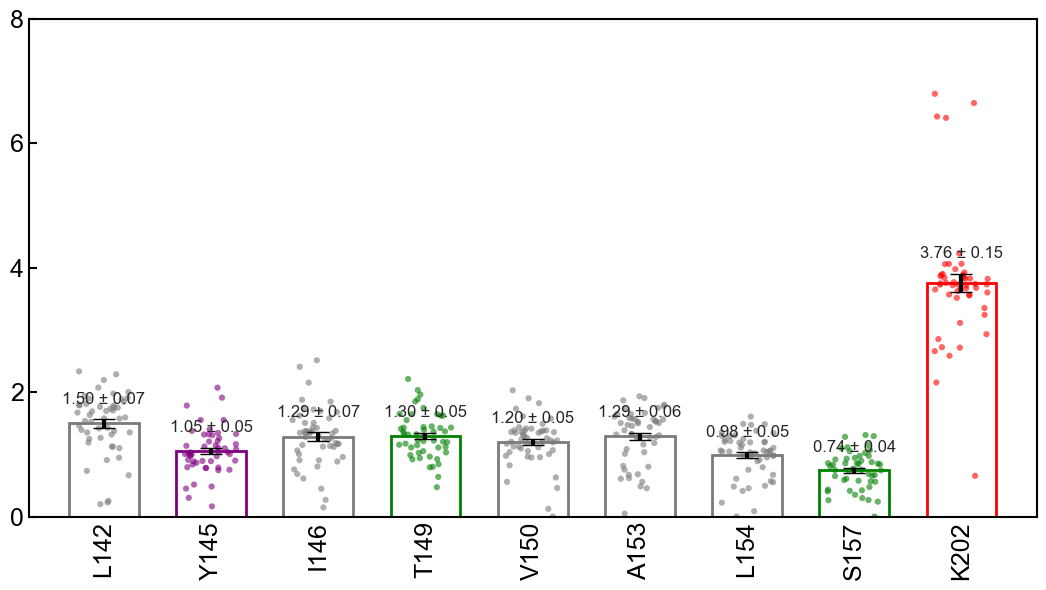

In [ ]:
h5_filename = r"output_rrcs_A_vs_B\rrcs_results_rrcs.h5"  
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"

with h5py.File(h5_filename, 'r') as hf:
    residue_pairs_A = hf['residue_pairs_A'][:]  
    residue_pairs_B = hf['residue_pairs_B'][:]  
    times = hf['times'][:]                    
    rrcs = hf['rrcs'][:]   

u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1 or resname AIB or resname ALY) and chainid A")
proteinB_pdb = u_pdb.select_atoms("protein and chainid B")

resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
resid_to_resname_B = {res.resid: res.resname for res in proteinB_pdb.residues}

def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Special')

resid_to_property_A = {resid: get_amino_acid_property(resname) for resid, resname in resid_to_resname_A.items()}
resid_to_property_B = {resid: get_amino_acid_property(resname) for resid, resname in resid_to_resname_B.items()}

bt = 500000.0   # 500 ns in ps
et = 1000000.0  # 1000 ns in ps
time_indices = np.where((times >= bt) & (times <= et))[0]
filtered_times = times[time_indices]

pl1_resids = [resid for resid, resname in resid_to_resname_A.items() if resname == 'PL1']
print("PL1 residue IDs in Protein A:", pl1_resids)

if len(pl1_resids) == 0:
    print("No PL1 residue found in Protein A.")
    pl1_resid = None
else:
    pl1_resid = pl1_resids[0]  

selected_residues_B = [142, 145, 146, 149, 150, 153, 154, 157, 202]

indices = np.where((residue_pairs_A == pl1_resid) & (np.isin(residue_pairs_B, selected_residues_B)))[0]
filtered_residue_pairs_A = residue_pairs_A[indices]
filtered_residue_pairs_B = residue_pairs_B[indices]
filtered_rrcs = rrcs[indices][:, time_indices]

rrcs_sum_B_filtered = {resid: np.zeros(len(filtered_times), dtype=np.float32) for resid in selected_residues_B}

for i in range(len(filtered_residue_pairs_B)):
    b_resid = filtered_residue_pairs_B[i]
    rrcs_sum_B_filtered[b_resid] += filtered_rrcs[i]

averaged_rrcs_sum_B = {}
averaged_rrcs_values_B = {}
frames_per_average = 100  

for resid in selected_residues_B:
    rrcs_sum = rrcs_sum_B_filtered[resid]
    num_complete_averages = len(rrcs_sum) // frames_per_average
    if num_complete_averages == 0:
        print(f"Residue {resid} has less than {frames_per_average} frames.")
        continue
    rrcs_sum_trimmed = rrcs_sum[:num_complete_averages * frames_per_average]
    averaged_rrcs = rrcs_sum_trimmed.reshape(-1, frames_per_average).mean(axis=1)
    averaged_rrcs_sum_B[resid] = averaged_rrcs.mean()
    averaged_rrcs_values_B[resid] = averaged_rrcs

data_for_plot_B = []
for resid in selected_residues_B:
    if resid not in averaged_rrcs_sum_B:
        continue
    mean = averaged_rrcs_sum_B[resid]
    se = np.std(averaged_rrcs_values_B[resid], ddof=1) / np.sqrt(len(averaged_rrcs_values_B[resid]))
    resname = resid_to_resname_B.get(resid, f"Res{resid}")
    property_B = get_amino_acid_property(resname)
    label = f"{resid}_{resname}"
    data_for_plot_B.append({'Resid': resid, 'Residue': label, 'Mean': mean, 'SE': se, 'Property': property_B, 'Values': averaged_rrcs_values_B[resid]})

df1_B = pd.DataFrame({
    'Residue': [item['Residue'] for item in data_for_plot_B],
    'Mean': [item['Mean'] for item in data_for_plot_B],
    'SE': [item['SE'] for item in data_for_plot_B],
    'Property': [item['Property'] for item in data_for_plot_B],
    'Resid': [item['Resid'] for item in data_for_plot_B]
})

df2_B = pd.DataFrame({
    'Residue': np.repeat([item['Residue'] for item in data_for_plot_B], len(data_for_plot_B[0]['Values'])),
    'Value': np.concatenate([item['Values'] for item in data_for_plot_B]),
    'Property': np.repeat([item['Property'] for item in data_for_plot_B], len(data_for_plot_B[0]['Values']))
})

aa_dict = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y',
    'AIB': 'AIB', 'PL1': 'PL1'
}

def modify_label(label):
    parts = label.split('_')
    if len(parts) == 2:
        resid, resname = parts
        if resname in aa_dict:
            return f"{aa_dict[resname]}{resid}"
        else:
            return f"{resname}{resid}"
    return label

df1_B['Modified_Residue'] = df1_B['Residue'].apply(modify_label)
df2_B['Modified_Residue'] = df2_B['Residue'].apply(modify_label)

df1_B['Color'] = df1_B['Property'].map(property_colors)
df1_B['Color'] = df1_B['Color'].fillna('#000000')
df2_B['Color'] = df2_B['Property'].map(property_colors)
df2_B['Color'] = df2_B['Color'].fillna('#000000')

df1_plot_B = df1_B.copy()
df2_plot_B = df2_B.copy()

residues_sorted_B = df1_plot_B['Modified_Residue'].tolist()
x_positions_B = np.arange(len(residues_sorted_B))
residue_to_x_B = {residue: x for x, residue in zip(x_positions_B, residues_sorted_B)}

df2_plot_B['X_num'] = df2_plot_B['Modified_Residue'].map(residue_to_x_B)
df2_clean_B = df2_plot_B.dropna(subset=['X_num'])

jitter_strength = 0.25 
jitter_B = np.random.uniform(-jitter_strength, jitter_strength, size=df2_clean_B.shape[0])

scatter_colors_B = df2_clean_B['Color'].values

plt.figure(figsize=(486/46,6), facecolor='white')

bars_B = plt.bar(x_positions_B, df1_plot_B['Mean'], yerr=df1_plot_B['SE'], 
                 color='white', edgecolor=df1_plot_B['Color'], linewidth=2, 
                 width=0.65, label='Mean RRCS', capsize=5, error_kw=dict(lw=3, capsize=8))

plt.scatter(df2_clean_B['X_num'] + jitter_B, df2_clean_B['Value'], 
            color=scatter_colors_B, alpha=0.6, 
            edgecolor='none', s=20, label='Individual RRCS')

for x_pos, mean, se in zip(x_positions_B, df1_plot_B['Mean'], df1_plot_B['SE']):
    label = f"{mean:.2f} ± {se:.2f}"
    plt.text(x_pos, mean + se + 0.2, label, ha='center', va='bottom', fontsize=12)
plt.ylim(0, 8)
plt.xticks(x_positions_B, df1_plot_B['Modified_Residue'], rotation=90, fontsize=18)
my_y_ticks = np.arange(0, 9, 2)
plt.yticks(my_y_ticks, fontsize=18)

ax = plt.gca()

for spine in ['left', 'bottom', 'right', 'top']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1.5)

ax.tick_params(axis='both', which='both', direction='in', length=6, width=1.5, colors='black', left=True)

plt.grid(False)

padding = 0.7  
ax.set_xlim(min(x_positions_B) - padding, max(x_positions_B) + padding)
ax.set_facecolor('white')

plt.tight_layout()

out_filename_B = "final_figure2/PL1_500ns_1000ns_Filtered_bar.jpg"
plt.savefig(out_filename_B, format='jpg', transparent=False)
plt.show()

### variation analysis

In [ ]:
target_residues = [201, 202, 205]  ###
target_rrcs_values = {resid: averaged_rrcs_values_B[resid] for resid in target_residues if resid in averaged_rrcs_values_B}
other_residues = [resid for resid in averaged_rrcs_values_B.keys() if resid not in target_residues]
other_rrcs_values = {resid: averaged_rrcs_values_B[resid] for resid in other_residues}


In [ ]:
from scipy.stats import ttest_ind, ttest_1samp
import numpy as np

other_rrcs_all = np.concatenate(list(other_rrcs_values.values()))
statistical_results = []

for resid in target_residues:
    if resid in target_rrcs_values:
        target_values = target_rrcs_values[resid]
        mean_value = np.mean(target_values)
        std_dev = np.std(target_values, ddof=1)  
        
        t_stat_ind, p_value_ind = ttest_ind(target_values, other_rrcs_all, equal_var=False)
        
        t_stat_1samp, p_value_1samp = ttest_1samp(target_values, 0)
        statistical_results.append({
            'Residue': f"{resid}_{resid_to_resname_B.get(resid, '')}",
            'Resid': resid,
            'Mean': mean_value,
            'StdDev': std_dev,
            't_stat_ind': t_stat_ind,
            'p_value_ind': p_value_ind,
            't_stat_1samp': t_stat_1samp,
            'p_value_1samp': p_value_1samp
        })
    else:
        print(f"Residue {resid} not found in data.")


In [ ]:
df_stats = pd.DataFrame(statistical_results)
output_csv_file = 'final_figure/L202_statistical_results.csv'
df_stats.to_csv(output_csv_file, index=False)
print(f"Statistical results have been saved to {output_csv_file}")
df_stats


Statistical results have been saved to final_figure/L202_statistical_results.csv


,Residue,Resid,Mean,StdDev,t_stat_ind,p_value_ind,t_stat_1samp,p_value_1samp
0,201_LEU,201,2.633831,0.810716,17.825970,1.866639e-23,22.972296,6.904983e-28
1,202_LYS,202,5.370989,0.962664,35.038880,6.490554e-37,39.451609,8.588322e-39
2,205_TYR,205,19.434782,1.542732,86.258511,1.443611e-55,89.078775,7.265643e-56


In [117]:
print("Statistical Test Results:")
for result in statistical_results:
    print(f"Residue {result['Residue']}:")
    print(f"  Independent t-test (vs others): t = {result['t_stat_ind']:.3f}, p = {result['p_value_ind']:.5f}")
    print(f"  One-sample t-test (vs 0): t = {result['t_stat_1samp']:.3f}, p = {result['p_value_1samp']:.5f}\n")


Statistical Test Results:
Residue 201_LEU:
  Independent t-test (vs others): t = 17.826, p = 0.00000
  One-sample t-test (vs 0): t = 22.972, p = 0.00000

Residue 202_LYS:
  Independent t-test (vs others): t = 35.039, p = 0.00000
  One-sample t-test (vs 0): t = 39.452, p = 0.00000

Residue 205_TYR:
  Independent t-test (vs others): t = 86.259, p = 0.00000
  One-sample t-test (vs 0): t = 89.079, p = 0.00000



In [ ]:
for index, row in df1_B.iterrows():
    resid = row['Resid']
    stat_result = next((item for item in statistical_results if int(item['Residue'].split('_')[0]) == resid), None)
    if stat_result:
        df1_B.at[index, 'p_value_ind'] = stat_result['p_value_ind']
        df1_B.at[index, 'p_value_1samp'] = stat_result['p_value_1samp']


In [119]:
df1_B

,Residue,Mean,SE,Property,Resid,Color,p_value_ind,p_value_1samp
0,28_ALA,0.028802,0.010995,Hydrophobic,28,#7A7A7A,NaN,NaN
1,29_THR,1.224642,0.173070,Polar uncharged,29,#008000,NaN,NaN
2,30_VAL,6.766381,0.188635,Hydrophobic,30,#7A7A7A,NaN,NaN
3,31_SER,10.094324,0.097466,Polar uncharged,31,#008000,NaN,NaN
4,32_LEU,11.361100,0.051251,Hydrophobic,32,#7A7A7A,NaN,NaN
...,...,...,...,...,...,...,...,...
391,419_ARG,0.000000,0.000000,Charged,419,#FF0000,NaN,NaN
392,420_TRP,0.000000,0.000000,Aromatic,420,#800080,NaN,NaN
393,421_ARG,0.000000,0.000000,Charged,421,#FF0000,NaN,NaN
394,422_LEU,0.000000,0.000000,Hydrophobic,422,#7A7A7A,NaN,NaN


# Plot

Accumulating RRCS sums: 100%|██████████| 15444/15444 [00:00<00:00, 15873.65it/s]


Statistical Test Results:
Residue 201_LEU:
  One-sample t-test (vs 0): t = 22.972, p = 0.00000

Residue 202_LYS:
  One-sample t-test (vs 0): t = 39.452, p = 0.00000

Residue 205_TYR:
  One-sample t-test (vs 0): t = 89.079, p = 0.00000



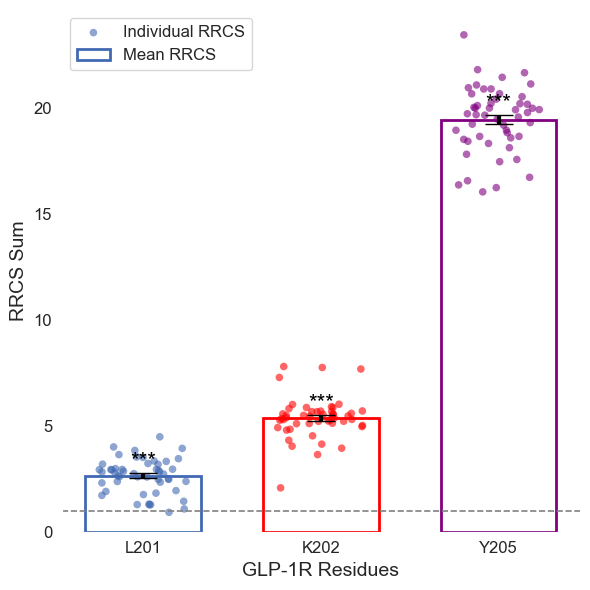

In [ ]:
h5_filename = r"output_rrcs_A_vs_B\rrcs_results_rrcs.h5"
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"

with h5py.File(h5_filename, 'r') as hf:
    residue_pairs_A = hf['residue_pairs_A'][:]
    residue_pairs_B = hf['residue_pairs_B'][:]
    times = hf['times'][:]
    rrcs = hf['rrcs'][:]

u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1 or resname AIB) and chainid A")
proteinB_pdb = u_pdb.select_atoms("protein and chainid B")

resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
resid_to_resname_B = {res.resid: res.resname for res in proteinB_pdb.residues}

amino_acid_properties = {
    'ALA': 'Hydrophobic', 'VAL': 'Hydrophobic', 'LEU': 'Hydrophobic', 'ILE': 'Hydrophobic',
    'PRO': 'Special', 'MET': 'Hydrophobic',
    'PHE': 'Aromatic', 'TYR': 'Aromatic', 'TRP': 'Aromatic',
    'HIS': 'Charged', 'LYS': 'Charged', 'ARG': 'Charged',
    'ASP': 'Charged', 'GLU': 'Charged',
    'ASN': 'Polar uncharged', 'GLN': 'Polar uncharged', 'SER': 'Polar uncharged', 'THR': 'Polar uncharged',
    'CYS': 'Special', 'GLY': 'Special', 'SEC': 'Special', 'UNK': 'Special',
    'PL1': 'Hydrophobic', 'AIB': 'Hydrophobic'
}

property_colors = {
    'Hydrophobic': '#4169B2',               # Royal Blue
    'Aromatic': '#800080',     # Purple
    'Charged': '#FF0000',      # Red
    'Polar uncharged': '#008000',           # Green
    'Special': '#FFA500'                    # Orange
}

def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Special')

resid_to_property_B = {}
for resid, resname in resid_to_resname_B.items():
    prop = get_amino_acid_property(resname)
    resid_to_property_B[resid] = prop

bt = 500000.0   # 500 ns in ps
et = 1000000.0  # 1000 ns in ps
time_indices = np.where((times >= bt) & (times <= et))[0]
filtered_times = times[time_indices]
filtered_rrcs = rrcs[:, time_indices]


unique_resid_B = np.unique(residue_pairs_B)
rrcs_sum_B_filtered = {resid: np.zeros(len(filtered_times), dtype=np.float32) for resid in unique_resid_B}

for i in tqdm(range(len(residue_pairs_B)), desc="Accumulating RRCS sums"):
    b_resid = residue_pairs_B[i]
    rrcs_sum_B_filtered[b_resid] += filtered_rrcs[i]

averaged_rrcs_sum_B = {}
averaged_rrcs_values_B = {}
frames_per_average = 100

for resid in unique_resid_B:
    rrcs_sum = rrcs_sum_B_filtered[resid]
    num_complete_averages = len(rrcs_sum) // frames_per_average
    if num_complete_averages == 0:
        continue
    rrcs_sum_trimmed = rrcs_sum[:num_complete_averages * frames_per_average]
    averaged_rrcs = rrcs_sum_trimmed.reshape(-1, frames_per_average).mean(axis=1)
    averaged_rrcs_sum_B[resid] = averaged_rrcs.mean()
    averaged_rrcs_values_B[resid] = averaged_rrcs

target_residues = [201, 202, 205]

data_for_plot_B = []
for resid in target_residues:
    if resid in averaged_rrcs_sum_B:
        mean = averaged_rrcs_sum_B[resid]
        se = np.std(averaged_rrcs_values_B[resid], ddof=1) / np.sqrt(len(averaged_rrcs_values_B[resid]))
        resname = resid_to_resname_B.get(resid, f"Res{resid}")
        property_B = get_amino_acid_property(resname)
        label = f"{resid}_{resname}"
        data_for_plot_B.append({
            'Resid': resid,
            'Residue': label,
            'Mean': mean,
            'SE': se,
            'Property': property_B,
            'Values': averaged_rrcs_values_B[resid]
        })
    else:
        print(f"Residue {resid} not found in data.")

from scipy.stats import ttest_1samp

statistical_results = []
for item in data_for_plot_B:
    resid = item['Resid']
    values = item['Values']

    t_stat, p_value = ttest_1samp(values, 0)

    statistical_results.append({
        'Residue': item['Residue'],
        't_stat': t_stat,
        'p_value': p_value
    })

for item, stat in zip(data_for_plot_B, statistical_results):
    item['p_value'] = stat['p_value']

print("Statistical Test Results:")
for result in statistical_results:
    print(f"Residue {result['Residue']}:")
    print(f"  One-sample t-test (vs 0): t = {result['t_stat']:.3f}, p = {result['p_value']:.5f}\n")

df1_B = pd.DataFrame({
    'Residue': [item['Residue'] for item in data_for_plot_B],
    'Mean': [item['Mean'] for item in data_for_plot_B],
    'SE': [item['SE'] for item in data_for_plot_B],
    'Property': [item['Property'] for item in data_for_plot_B],
    'Resid': [item['Resid'] for item in data_for_plot_B],
    'p_value': [item['p_value'] for item in data_for_plot_B]
})

df2_B = pd.DataFrame({
    'Residue': np.repeat([item['Residue'] for item in data_for_plot_B], [len(item['Values']) for item in data_for_plot_B]),
    'Value': np.concatenate([item['Values'] for item in data_for_plot_B]),
    'Property': np.repeat([item['Property'] for item in data_for_plot_B], [len(item['Values']) for item in data_for_plot_B])
})

df1_B['Color'] = df1_B['Property'].map(property_colors)
df1_B['Color'] = df1_B['Color'].fillna('#000000')
df2_B['Color'] = df2_B['Property'].map(property_colors)
df2_B['Color'] = df2_B['Color'].fillna('#000000')

aa_dict = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y',
    'AIB': 'AIB'
}

def modify_label(label):
    parts = label.split('_')
    if len(parts) == 2:
        resid, resname = parts
        if resname in aa_dict:
            return f"{aa_dict[resname]}{resid}"
        else:
            return f"{resname}{resid}"
    return label

df1_B['Modified_Residue'] = df1_B['Residue'].apply(modify_label)
df2_B['Modified_Residue'] = df2_B['Residue'].apply(modify_label)

df1_plot_B = df1_B.copy()
df2_plot_B = df2_B.copy()

residues_sorted_B = df1_plot_B['Modified_Residue'].tolist()
x_positions_B = np.arange(len(residues_sorted_B))

residue_to_x_B = {residue: x for x, residue in zip(x_positions_B, residues_sorted_B)}
df2_plot_B['X_num'] = df2_plot_B['Modified_Residue'].map(residue_to_x_B)
df2_clean_B = df2_plot_B.dropna(subset=['X_num'])

jitter_strength = 0.25  
np.random.seed(114514) 
jitter_B = np.random.uniform(-jitter_strength, jitter_strength, size=df2_clean_B.shape[0])

scatter_colors_B = df2_clean_B['Color'].values

plt.figure(figsize=(6, 6), facecolor='white')
bars_B = plt.bar(x_positions_B, df1_plot_B['Mean'], yerr=df1_plot_B['SE'], 
                 color='white', edgecolor=df1_plot_B['Color'], linewidth=2, 
                 width=0.65, label='Mean RRCS', capsize=5, error_kw=dict(lw=3, capsize=10))

plt.scatter(df2_clean_B['X_num'] + jitter_B, df2_clean_B['Value'], 
            color=scatter_colors_B, alpha=0.6, 
            edgecolor='none', s=30, label='Individual RRCS')

plt.axhline(y=1, linestyle='dashed', linewidth=1.2, color='gray')
plt.xlabel("GLP-1R Residues", fontsize=14)
plt.ylabel("RRCS Sum", fontsize=14)
plt.xticks(x_positions_B, df1_plot_B['Modified_Residue'], rotation=0, fontsize=12)
plt.yticks(fontsize=12)

for i, row in df1_plot_B.iterrows():
    p_value = row['p_value']
    x = x_positions_B[i]
    y = row['Mean'] + row['SE'] + 0.1  
    if p_value < 0.001:
        plt.text(x, y, '***', ha='center', va='bottom', color='black', fontsize=16)
    elif p_value < 0.01:
        plt.text(x, y, '**', ha='center', va='bottom', color='black', fontsize=16)
    elif p_value < 0.05:
        plt.text(x, y, '*', ha='center', va='bottom', color='black', fontsize=16)

plt.legend(fontsize=12)
plt.grid(False)
plt.tight_layout()
out_filename_B = "final_figure/Recptor_500ns_1000ns_L201_K202_Y205_toge.png"
plt.savefig(out_filename_B, format='png', transparent=False)
plt.show()


Accumulating RRCS sums: 100%|██████████| 15444/15444 [00:00<00:00, 20416.73it/s]


Statistical Test Results:
Residue 138_GLU:
  One-sample t-test (vs 0): t = 22.570, p = 0.00000

Residue 141_LEU:
  One-sample t-test (vs 0): t = 34.663, p = 0.00000

Residue 142_LEU:
  One-sample t-test (vs 0): t = 32.796, p = 0.00000

Residue 145_TYR:
  One-sample t-test (vs 0): t = 30.565, p = 0.00000

Residue 146_ILE:
  One-sample t-test (vs 0): t = 19.582, p = 0.00000

Residue 148_TYR:
  One-sample t-test (vs 0): t = 13.909, p = 0.00000

Residue 149_THR:
  One-sample t-test (vs 0): t = 25.644, p = 0.00000

Residue 150_VAL:
  One-sample t-test (vs 0): t = 22.248, p = 0.00000

Residue 153_ALA:
  One-sample t-test (vs 0): t = 20.789, p = 0.00000

Residue 154_LEU:
  One-sample t-test (vs 0): t = 19.099, p = 0.00000

Residue 190_ARG:
  One-sample t-test (vs 0): t = 12.018, p = 0.00000

Residue 197_LYS:
  One-sample t-test (vs 0): t = 11.146, p = 0.00000

Residue 201_LEU:
  One-sample t-test (vs 0): t = 22.972, p = 0.00000

Residue 202_LYS:
  One-sample t-test (vs 0): t = 39.452, p = 0.0

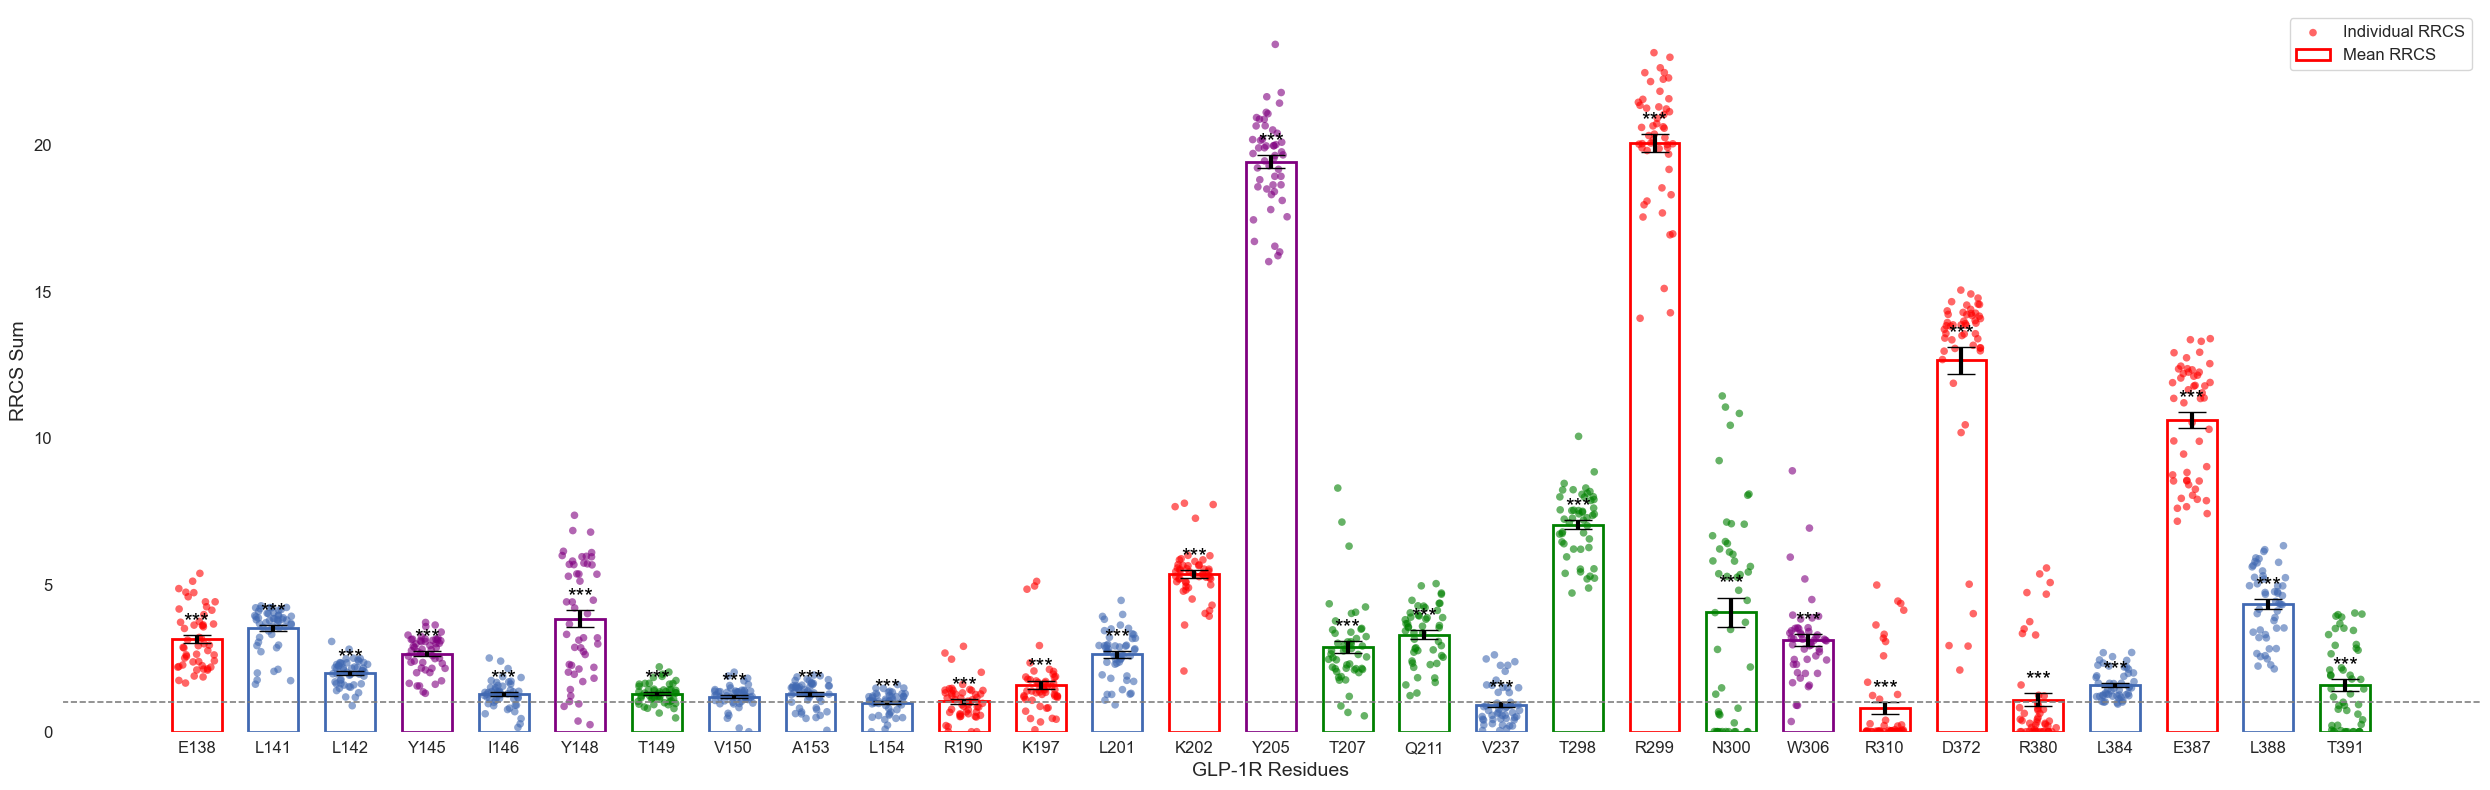

In [121]:
# 导入必要的库
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import ttest_1samp
import MDAnalysis as mda

# =======================
# 1. 数据加载和预处理
# =======================
h5_filename = r"output_rrcs_A_vs_B\rrcs_results_rrcs.h5"
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"

with h5py.File(h5_filename, 'r') as hf:
    residue_pairs_A = hf['residue_pairs_A'][:]
    residue_pairs_B = hf['residue_pairs_B'][:]
    times = hf['times'][:]
    rrcs = hf['rrcs'][:]

u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1 or resname AIB) and chainid A")
proteinB_pdb = u_pdb.select_atoms("protein and chainid B")

resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
resid_to_resname_B = {res.resid: res.resname for res in proteinB_pdb.residues}

# 定义氨基酸性质和颜色映射
amino_acid_properties = {
    'ALA': 'Hydrophobic', 'VAL': 'Hydrophobic', 'LEU': 'Hydrophobic', 'ILE': 'Hydrophobic',
    'PRO': 'Special', 'MET': 'Hydrophobic',
    'PHE': 'Aromatic', 'TYR': 'Aromatic', 'TRP': 'Aromatic',
    'HIS': 'Charged', 'LYS': 'Charged', 'ARG': 'Charged',
    'ASP': 'Charged', 'GLU': 'Charged',
    'ASN': 'Polar uncharged', 'GLN': 'Polar uncharged', 'SER': 'Polar uncharged', 'THR': 'Polar uncharged',
    'CYS': 'Special', 'GLY': 'Special', 'SEC': 'Special', 'UNK': 'Special',
    'PL1': 'Hydrophobic', 'AIB': 'Hydrophobic'
}

property_colors = {
    'Hydrophobic': '#4169B2',               # Royal Blue
    'Aromatic': '#800080',     # Purple
    'Charged': '#FF0000',      # Red
    'Polar uncharged': '#008000',           # Green
    'Special': '#FFA500'                    # Orange
}

def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Special')

resid_to_property_B = {}
for resid, resname in resid_to_resname_B.items():
    prop = get_amino_acid_property(resname)
    resid_to_property_B[resid] = prop

# =======================
# 2. 数据过滤和RRCS计算
# =======================
# 定义时间窗口
bt = 500000.0   # 500 ns in ps
et = 1000000.0  # 1000 ns in ps
time_indices = np.where((times >= bt) & (times <= et))[0]
filtered_times = times[time_indices]
filtered_rrcs = rrcs[:, time_indices]

# 计算每个残基B的RRCS和
unique_resid_B = np.unique(residue_pairs_B)
rrcs_sum_B_filtered = {resid: np.zeros(len(filtered_times), dtype=np.float32) for resid in unique_resid_B}

for i in tqdm(range(len(residue_pairs_B)), desc="Accumulating RRCS sums"):
    b_resid = residue_pairs_B[i]
    rrcs_sum_B_filtered[b_resid] += filtered_rrcs[i]

# 计算每个残基B的平均RRCS值
averaged_rrcs_sum_B = {}
averaged_rrcs_values_B = {}
frames_per_average = 100

for resid in unique_resid_B:
    rrcs_sum = rrcs_sum_B_filtered[resid]
    num_complete_averages = len(rrcs_sum) // frames_per_average
    if num_complete_averages == 0:
        continue
    rrcs_sum_trimmed = rrcs_sum[:num_complete_averages * frames_per_average]
    averaged_rrcs = rrcs_sum_trimmed.reshape(-1, frames_per_average).mean(axis=1)
    averaged_rrcs_sum_B[resid] = averaged_rrcs.mean()
    averaged_rrcs_values_B[resid] = averaged_rrcs

# =======================
# 3. 提取指定残基的数据（201, 202, 205）
# =======================
target_residues = [138, 141, 142, 145, 146, 148, 149, 150, 153, 154, 190, 197, 201, 202, 205,
                   207, 211, 237, 298, 299, 300, 306, 310, 372, 380, 384, 387, 388, 391]

data_for_plot_B = []
for resid in target_residues:
    if resid in averaged_rrcs_sum_B:
        mean = averaged_rrcs_sum_B[resid]
        se = np.std(averaged_rrcs_values_B[resid], ddof=1) / np.sqrt(len(averaged_rrcs_values_B[resid]))
        resname = resid_to_resname_B.get(resid, f"Res{resid}")
        property_B = get_amino_acid_property(resname)
        label = f"{resid}_{resname}"
        data_for_plot_B.append({
            'Resid': resid,
            'Residue': label,
            'Mean': mean,
            'SE': se,
            'Property': property_B,
            'Values': averaged_rrcs_values_B[resid]
        })
    else:
        print(f"Residue {resid} not found in data.")

# =======================
# 4. 统计显著性分析
# =======================
# 我们将对每个目标残基进行单样本t检验，与0进行比较

# 导入t检验函数
from scipy.stats import ttest_1samp

statistical_results = []
for item in data_for_plot_B:
    resid = item['Resid']
    values = item['Values']
    # 单样本t检验（与0比较）
    t_stat, p_value = ttest_1samp(values, 0)
    # 存储结果
    statistical_results.append({
        'Residue': item['Residue'],
        't_stat': t_stat,
        'p_value': p_value
    })

# 将p值添加到data_for_plot_B中
for item, stat in zip(data_for_plot_B, statistical_results):
    item['p_value'] = stat['p_value']

# 输出统计结果
print("Statistical Test Results:")
for result in statistical_results:
    print(f"Residue {result['Residue']}:")
    print(f"  One-sample t-test (vs 0): t = {result['t_stat']:.3f}, p = {result['p_value']:.5f}\n")

# =======================
# 5. 数据准备和绘图
# =======================
# 创建数据框
df1_B = pd.DataFrame({
    'Residue': [item['Residue'] for item in data_for_plot_B],
    'Mean': [item['Mean'] for item in data_for_plot_B],
    'SE': [item['SE'] for item in data_for_plot_B],
    'Property': [item['Property'] for item in data_for_plot_B],
    'Resid': [item['Resid'] for item in data_for_plot_B],
    'p_value': [item['p_value'] for item in data_for_plot_B]
})

df2_B = pd.DataFrame({
    'Residue': np.repeat([item['Residue'] for item in data_for_plot_B], [len(item['Values']) for item in data_for_plot_B]),
    'Value': np.concatenate([item['Values'] for item in data_for_plot_B]),
    'Property': np.repeat([item['Property'] for item in data_for_plot_B], [len(item['Values']) for item in data_for_plot_B])
})

# 映射颜色
df1_B['Color'] = df1_B['Property'].map(property_colors)
df1_B['Color'] = df1_B['Color'].fillna('#000000')
df2_B['Color'] = df2_B['Property'].map(property_colors)
df2_B['Color'] = df2_B['Color'].fillna('#000000')

# 修改Residue标签
aa_dict = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y',
    'AIB': 'AIB'
}

def modify_label(label):
    parts = label.split('_')
    if len(parts) == 2:
        resid, resname = parts
        if resname in aa_dict:
            return f"{aa_dict[resname]}{resid}"
        else:
            return f"{resname}{resid}"
    return label

df1_B['Modified_Residue'] = df1_B['Residue'].apply(modify_label)
df2_B['Modified_Residue'] = df2_B['Residue'].apply(modify_label)

# 准备绘图数据
df1_plot_B = df1_B.copy()
df2_plot_B = df2_B.copy()

# 定义x轴位置
residues_sorted_B = df1_plot_B['Modified_Residue'].tolist()
x_positions_B = np.arange(len(residues_sorted_B))

# 映射Residue到x轴位置
residue_to_x_B = {residue: x for x, residue in zip(x_positions_B, residues_sorted_B)}
df2_plot_B['X_num'] = df2_plot_B['Modified_Residue'].map(residue_to_x_B)
df2_clean_B = df2_plot_B.dropna(subset=['X_num'])

# 创建抖动以避免散点重叠
jitter_strength = 0.25  # 可调整抖动强度
np.random.seed(114514)  # 确保可重复性
jitter_B = np.random.uniform(-jitter_strength, jitter_strength, size=df2_clean_B.shape[0])

scatter_colors_B = df2_clean_B['Color'].values

# =======================
# 6. 绘制柱状图、散点图、误差棒和显著性标记
# =======================
plt.figure(figsize=(25, 8), facecolor='white')
bars_B = plt.bar(x_positions_B, df1_plot_B['Mean'], yerr=df1_plot_B['SE'], 
                 color='white', edgecolor=df1_plot_B['Color'], linewidth=2, 
                 width=0.65, label='Mean RRCS', capsize=5, error_kw=dict(lw=3, capsize=10))

# 绘制散点
plt.scatter(df2_clean_B['X_num'] + jitter_B, df2_clean_B['Value'], 
            color=scatter_colors_B, alpha=0.6, 
            edgecolor='none', s=30, label='Individual RRCS')

plt.axhline(y=1, linestyle='dashed', linewidth=1.2, color='gray')
plt.xlabel("GLP-1R Residues", fontsize=14)
plt.ylabel("RRCS Sum", fontsize=14)
plt.xticks(x_positions_B, df1_plot_B['Modified_Residue'], rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# 添加显著性标记
for i, row in df1_plot_B.iterrows():
    p_value = row['p_value']
    x = x_positions_B[i]
    y = row['Mean'] + row['SE'] + 0.1  # 在误差棒上方一点
    if p_value < 0.001:
        plt.text(x, y, '***', ha='center', va='bottom', color='black', fontsize=16)
    elif p_value < 0.01:
        plt.text(x, y, '**', ha='center', va='bottom', color='black', fontsize=16)
    elif p_value < 0.05:
        plt.text(x, y, '*', ha='center', va='bottom', color='black', fontsize=16)

plt.legend(fontsize=12)
plt.grid(False)
plt.tight_layout()
out_filename_B = "final_figure/Recptor_500ns_1000ns_select.png"
plt.savefig(out_filename_B, format='png', transparent=False)
plt.show()


### 两两检验

In [122]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

residue_values = {
    item['Resid']: item['Values']
    for item in data_for_plot_B
}


In [123]:
residue_values


{138: array([3.9917333, 3.5740006, 4.7403746, 2.0994444, 2.1449955, 4.8784776,
        4.1419587, 4.2591457, 1.659162 , 1.8670474, 2.8767145, 2.132823 ,
        5.1298122, 4.428155 , 4.1831727, 2.394209 , 3.519591 , 4.7545857,
        3.617451 , 3.7314432, 2.251246 , 2.765351 , 2.5691972, 2.2022011,
        1.898302 , 2.9323165, 2.6173816, 2.1044827, 3.1799743, 2.6430008,
        2.6204324, 2.855147 , 3.6718943, 2.2748384, 2.3800445, 4.4289846,
        3.1250217, 2.9506207, 3.6413505, 1.7476943, 4.59985  , 2.9976885,
        2.5113287, 2.202722 , 2.2199345, 3.214922 , 2.4170973, 3.634431 ,
        5.3981805, 3.7611837], dtype=float32),
 141: array([3.6826658, 4.0535154, 4.1970434, 4.1051574, 3.8201046, 2.9524448,
        4.2905865, 4.2251754, 3.912745 , 3.8322136, 4.2363753, 3.7921786,
        3.9569738, 3.858676 , 3.9619098, 4.1651835, 3.6975589, 2.9349506,
        3.8835812, 3.7922301, 3.7167459, 3.588476 , 3.0511713, 1.7618042,
        2.8628442, 3.6873777, 4.2276096, 3.9349515, 3.8

In [124]:
# 初始化列表来存储结果
pairwise_results = []

residues = list(residue_values.keys())

for i in range(len(residues)):
    for j in range(i+1, len(residues)):
        resid1 = residues[i]
        resid2 = residues[j]
        values1 = residue_values[resid1]
        values2 = residue_values[resid2]
        
        # 独立样本 t 检验
        t_stat, p_value = ttest_ind(values1, values2, equal_var=False)
        
        pairwise_results.append({
            'Residue1': resid1,
            'Residue2': resid2,
            't_stat': t_stat,
            'p_value': p_value
        })


In [125]:
# 提取所有未校正的 p 值
raw_p_values = [result['p_value'] for result in pairwise_results]

# 使用 Benjamini-Hochberg 方法进行校正
rejected, corrected_p_values, _, _ = multipletests(raw_p_values, alpha=0.05, method='fdr_bh')

# 将校正后的 p 值添加回结果中
for i, result in enumerate(pairwise_results):
    result['corrected_p_value'] = corrected_p_values[i]
    result['significant'] = rejected[i]


In [126]:
# 将结果转换为 DataFrame
df_pairwise = pd.DataFrame(pairwise_results)

# 显示结果
print("两两比较结果：")
for index, row in df_pairwise.iterrows():
    resid1 = row['Residue1']
    resid2 = row['Residue2']
    t_stat = row['t_stat']
    p_value = row['p_value']
    corrected_p_value = row['corrected_p_value']
    significant = row['significant']
    print(f"残基 {resid1} vs 残基 {resid2}:")
    print(f"  t = {t_stat:.3f}, 未校正 p = {p_value:.5f}, 校正后 p = {corrected_p_value:.5f}, 显著性：{significant}")
    print()


两两比较结果：
残基 138 vs 残基 141:
  t = -2.147, 未校正 p = 0.03453, 校正后 p = 0.04076, 显著性：True

残基 138 vs 残基 142:
  t = 7.573, 未校正 p = 0.00000, 校正后 p = 0.00000, 显著性：True

残基 138 vs 残基 145:
  t = 3.065, 未校正 p = 0.00295, 校正后 p = 0.00371, 显著性：True

残基 138 vs 残基 146:
  t = 12.119, 未校正 p = 0.00000, 校正后 p = 0.00000, 显著性：True

残基 138 vs 残基 148:
  t = -2.246, 未校正 p = 0.02772, 校正后 p = 0.03311, 显著性：True

残基 138 vs 残基 149:
  t = 12.486, 未校正 p = 0.00000, 校正后 p = 0.00000, 显著性：True

残基 138 vs 残基 150:
  t = 13.074, 未校正 p = 0.00000, 校正后 p = 0.00000, 显著性：True

残基 138 vs 残基 153:
  t = 12.231, 未校正 p = 0.00000, 校正后 p = 0.00000, 显著性：True

残基 138 vs 残基 154:
  t = 14.578, 未校正 p = 0.00000, 校正后 p = 0.00000, 显著性：True

残基 138 vs 残基 190:
  t = 12.852, 未校正 p = 0.00000, 校正后 p = 0.00000, 显著性：True

残基 138 vs 残基 197:
  t = 7.766, 未校正 p = 0.00000, 校正后 p = 0.00000, 显著性：True

残基 138 vs 残基 201:
  t = 2.902, 未校正 p = 0.00462, 校正后 p = 0.00575, 显著性：True

残基 138 vs 残基 202:
  t = -11.330, 未校正 p = 0.00000, 校正后 p = 0.00000, 显著性：True

残基 138 

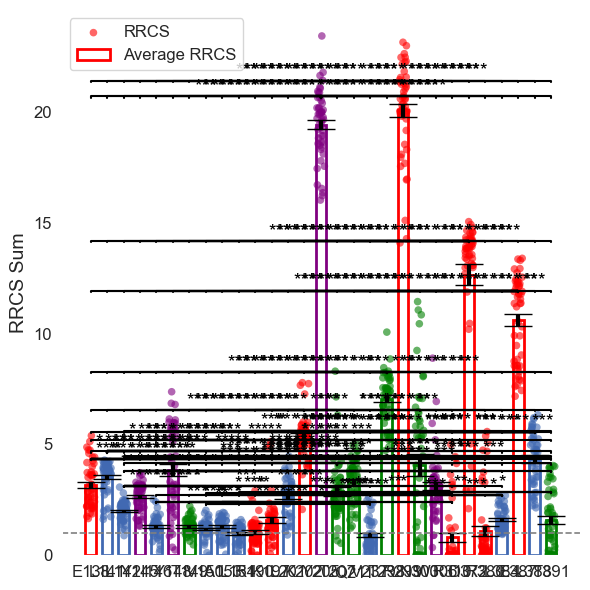

In [127]:
# 绘制图形（与之前类似）
plt.figure(figsize=(6, 6), facecolor='white')
bars_B = plt.bar(x_positions_B, df1_plot_B['Mean'], yerr=df1_plot_B['SE'], 
                 color='white', edgecolor=df1_plot_B['Color'], linewidth=2, 
                 width=0.65, label='Average RRCS', capsize=5, error_kw=dict(lw=3, capsize=10))
# 绘制散点
plt.scatter(df2_clean_B['X_num'] + jitter_B, df2_clean_B['Value'], 
            color=scatter_colors_B, alpha=0.6, 
            edgecolor='none', s=30, label='RRCS')

plt.axhline(y=1, linestyle='dashed', linewidth=1.2, color='gray')
plt.xlabel("", fontsize=14)
plt.ylabel("RRCS Sum", fontsize=14)
plt.xticks(x_positions_B, df1_plot_B['Modified_Residue'], rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# 添加两两显著性标记
from matplotlib.lines import Line2D

# 定义每个残基的 x 位置
residue_to_xpos = {resid: x for resid, x in zip(df1_plot_B['Resid'], x_positions_B)}

# 添加显著性标记
for index, row in df_pairwise.iterrows():
    if row['significant']:
        resid1 = row['Residue1']
        resid2 = row['Residue2']
        x1 = residue_to_xpos[resid1]
        x2 = residue_to_xpos[resid2]
        
        # 提取标量值
        mean1 = df1_plot_B.loc[df1_plot_B['Resid'] == resid1, 'Mean'].values[0]
        se1 = df1_plot_B.loc[df1_plot_B['Resid'] == resid1, 'SE'].values[0]
        mean2 = df1_plot_B.loc[df1_plot_B['Resid'] == resid2, 'Mean'].values[0]
        se2 = df1_plot_B.loc[df1_plot_B['Resid'] == resid2, 'SE'].values[0]
        
        y_max = max(mean1 + se1, mean2 + se2)
        y = y_max + 1  # 在柱状图上方一点
        
        # 绘制方括号
        plt.plot([x1, x1, x2, x2], [y, y+0.05, y+0.05, y], lw=1.5, c='k')
        
        # 添加显著性星号
        p_value = row['corrected_p_value']
        if p_value < 0.001:
            stars = '***'
        elif p_value < 0.01:
            stars = '**'
        elif p_value < 0.05:
            stars = '*'
        else:
            stars = ''
        plt.text((x1 + x2) / 2, y + 0.05, stars, ha='center', va='bottom', color='black', fontsize=14)

plt.legend(fontsize=12)
plt.grid(False)
out_filename_B = "final_figure/Recptor_500ns_1000ns_201_202_205_ttest.png"
plt.savefig(out_filename_B, format='png', transparent=False)
plt.tight_layout()
plt.show()


In [128]:
row

Residue1                   388
Residue2                   391
t_stat               10.544265
p_value                    0.0
corrected_p_value          0.0
significant               True
Name: 405, dtype: object